# View Color light-Curves and Histograms for repeatability

- author Sylvie Dagoret-Campagne
- creation date 2024-09-07
- last update 2024-09-08

In [1]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor=None, alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import SigmaClip


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

import scipy
from scipy.optimize import curve_fit

In [4]:
#inputfilename = "sources_objectTable-t3864-multibands-o912-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv"

## The two lists:
theta_sep = 300.
time_sep = 1800.
NMAX = 50

BAND1 = "G"
BAND2 = "R"

#BAND1 = "Z"
#BAND2 = "Y"

CBAND = f"{BAND1}-{BAND2}"
CBANDtag = f"{BAND1}_{BAND2}"

path_colorlc = f"data_coloredlightcurves{CBANDtag}_thmax_{theta_sep:.0f}_tmax_{time_sep:.0f}"

summary_file = f"photompairsummary{CBANDtag}_thmax_{theta_sep:.0f}_tmax_{time_sep:.0f}.csv"
fntag = f"^color_lightcurve{CBANDtag}_(.*)_thmax_{theta_sep:.0f}_tmax_{time_sep:.0f}.csv$"

summary_fullfilename= os.path.join(path_colorlc,summary_file) 

dfc = pd.read_csv(summary_fullfilename,index_col=0)

In [5]:
dfc

idx_pair  idx_obj1  idx_obj2    sep  refcol_psf_md  n_refcol_psf  \
0         0.0     141.0     907.0    7.0       0.245792          54.0   
1         1.0     654.0     669.0   10.0       0.201248          14.0   
2         2.0     111.0     262.0   16.0       0.390104         102.0   
3         3.0     813.0     950.0   16.0       0.516337          48.0   
4         4.0      64.0     262.0   18.0       0.334823          96.0   
..        ...       ...       ...    ...            ...           ...   
973     997.0     141.0     654.0  299.0       0.415387          11.0   
974     998.0     392.0     654.0  299.0       0.175354           8.0   
975     999.0     369.0     721.0  299.0       0.093145           2.0   
976    1000.0     201.0     392.0  299.0       0.136615          36.0   
977    1001.0     201.0     824.0  299.0       0.965099          12.0   

     refcol_ap_md  n_refcol_ap    muclip  sigmaclip  nclip     magmax  
0        0.241321         54.0  0.243219   0.021885   54.0  16.324735  
1        0.197477         14.0  0.197428   0.009260   14.0  15.166812  
2        0.396171        102.0  0.396514   0.015744  102.0  15.853043  
3        0.519901         48.0  0.520206   0.026406   48.0  16.395164  
4        0.340353         96.0  0.340714   0.014137   96.0  15.777518  
..            ...          ...       ...        ...    ...        ...  
973      0.400365         11.0  0.396339   0.016838   11.0  15.417780  
974      0.140779          8.0  0.140760   0.005477    8.0  14.342296  
975      0.083797          2.0  0.083797   0.036565    2.0  15.652288  
976      0.139459         36.0  0.141339   0.014815   36.0  15.738955  
977      0.967364         12.0  0.972415   0.025732   12.0  15.807190  

[978 rows x 12 columns]

In [6]:
len(dfc.idx_pair.unique())

978

In [7]:
list_of_files = os.listdir(path_colorlc) 

In [8]:
all_pairnum = []
for idx,file in enumerate(list_of_files):
    coll = re.findall(fntag,file)
    if len(coll)>0:
        all_pairnum.append(int(coll[0]))
        
all_pairnum = sorted(all_pairnum)  

In [9]:
print(all_pairnum) 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [10]:
all_df = []
for idx,idx_pair in enumerate(all_pairnum):
    idx_pair_str = str(idx_pair).zfill(4)
    filename =  f"color_lightcurve{CBANDtag}_{idx_pair_str}_thmax_{theta_sep:.0f}_tmax_{time_sep:.0f}.csv"
    fullfilename = os.path.join(path_colorlc,filename)
    df = pd.read_csv(fullfilename,index_col=0)
    all_df.append(df)
    

In [11]:
df = all_df[0]

### Definitions

            # first indec band, second index star
            # Star 1 in band 1
            psfMag11 =  row_pair_b1["psfMag_x"]
            
            if FLAG_AP_FLUX_CAL:
                apMag11 =  row_pair_b1["apFlux_35_0_calMag_x"]
            else:
                apMag11 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_x"])
 
            # Star 2 in band 1
            psfMag12 =  row_pair_b1["psfMag_y"]


            if FLAG_AP_FLUX_CAL:
                apMag12 =  row_pair_b1["apFlux_35_0_calMag_y"]
  
            else:
                apMag12 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_y"])
 
            # Star 1 in band 2
            psfMag21 =  row_pair_b2["psfMag_x"]

            if FLAG_AP_FLUX_CAL:
                apMag21 =  row_pair_b2["apFlux_35_0_calMag_x"]
            else:
                apMag21 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_x"])

            
            # Star 2 in band 2
            psfMag22 =  row_pair_b2["psfMag_y"]

            
            if FLAG_AP_FLUX_CAL:
                apMag22 =  row_pair_b2["apFlux_35_0_calMag_y"]
            else:
                apMag22 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_y"])

        

In [12]:
df.head()

band1      exposure1                          time1   psfMag11   psfMag12  \
0     g  2023112700345  2023-11-28 07:24:53.839493888  15.394361  16.341429   
1     g  2023112700353  2023-11-28 07:32:33.813998080  15.393639  16.321255   
2     g  2023112700357  2023-11-28 07:36:23.772502016  15.411370  16.354874   
3     g  2023120400585  2023-12-05 07:14:47.779991040  15.431722  16.354009   
4     g  2023120400589  2023-12-05 07:18:34.897998080  15.444205  16.358171   

   psfMagErr11  psfMagErr12    apMag11    apMag12  apMagErr11  apMagErr12  \
0     0.005133     0.008551  15.384073  16.361838    0.006894    0.016704   
1     0.004822     0.007620  15.396599  16.330897    0.007165    0.016071   
2     0.005058     0.008192  15.387179  16.368798    0.006905    0.016085   
3     0.004703     0.007547  15.416259  16.324682    0.006530    0.013881   
4     0.004627     0.007490  15.424241  16.360598    0.006790    0.015045   

  band2      exposure2                          time2   psfMag21   psfMag22  \
0     r  2023112700346  2023-11-28 07:25:40.615503872  14.642168  15.317250   
1     r  2023112700358  2023-11-28 07:37:10.383496960  14.669641  15.352447   
2     r  2023112700358  2023-11-28 07:37:10.383496960  14.669641  15.352447   
3     r  2023120400586  2023-12-05 07:15:34.482998016  14.674107  15.347778   
4     r  2023120400590  2023-12-05 07:19:21.850491904  14.663909  15.336022   

   psfMagErr21  psfMagErr22    apMag21    apMag22  apMagErr21  apMagErr22  \
0     0.003681     0.005035  14.629194  15.324140    0.004297    0.007885   
1     0.003843     0.005174  14.661529  15.356039    0.004323    0.007601   
2     0.003843     0.005174  14.661529  15.356039    0.004323    0.007601   
3     0.003548     0.004837  14.662634  15.332661    0.004261    0.007196   
4     0.003565     0.004826  14.654035  15.335200    0.004379    0.007577   

           dt  airmassb1  airmassb2          x11         y11          x12  \
0   46.776009   1.030945   1.030285  2001.208579  733.366565  2065.686134   
1  276.569498   1.024954   1.021743   903.719680  747.126967   968.064910   
2   46.610994   1.022272   1.021743   352.006313  748.378755   416.379492   
3   46.703006   1.018387   1.017926  1475.183783  937.727926  1539.592133   
4   46.952493   1.016264   1.015841   929.403584  945.772656   993.888902   

          y12          x21         y21          x22         y22  \
0  785.999627  2002.672080  733.573780  2067.138841  786.155962   
1  799.650909   355.092148  749.123475   419.512423  801.820769   
2  800.993288   355.092148  749.123475   419.512423  801.820769   
3  990.288077  1476.075032  937.479721  1540.502766  990.107933   
4  998.361785   932.150228  944.370764   996.563109  996.964716   

   deltapsfmag_s12b1  deltapsfmagErr_s12b1  deltaapmag_s12b1  \
0          -0.947068              0.009974         -0.977765   
1          -0.927616              0.009017         -0.934297   
2          -0.943504              0.009627         -0.981619   
3          -0.922287              0.008892         -0.908423   
4          -0.913966              0.008804         -0.936357   

   deltaapmagErr_s12b1  deltapsfmag_s12b2  deltapsfmagErr_s12b2  \
0             0.018071          -0.675082              0.006237   
1             0.017596          -0.682806              0.006444   
2             0.017504          -0.682806              0.006444   
3             0.015340          -0.673671              0.005998   
4             0.016506          -0.672113              0.006000   

   deltaapmag_s12b2  deltaapmagErr_s12b2  psfcol12_s1  psfcol12Err_s1  \
0         -0.694946             0.008980     0.752193        0.006317   
1         -0.694510             0.008745     0.723998        0.006166   
2         -0.694510             0.008745     0.741729        0.006352   
3         -0.670027             0.008363     0.757615        0.005891   
4         -0.681165             0.008751     0.780296        0.005841   

   apcol12_s1  apcol12Err_s1  psf

        # band 1 : mag_star1-mag_star2 
        df_col_b1b2["deltapsfmag_s12b1"] =    (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag12"])
        df_col_b1b2["deltapsfmagErr_s12b1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr12"]**2)

        df_col_b1b2["deltaapmag_s12b1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag12"])
        df_col_b1b2["deltaapmagErr_s12b1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr12"]**2)
    
        # band 2 : mag_star1-mag_star2 
        df_col_b1b2["deltapsfmag_s12b2"] = (df_col_b1b2["psfMag21"] - df_col_b1b2["psfMag22"])
        df_col_b1b2["deltapsfmagErr_s12b2"] = np.sqrt(df_col_b1b2["psfMagErr21"]**2 + df_col_b1b2["psfMagErr22"]**2)
        df_col_b1b2["deltaapmag_s12b2"] = (df_col_b1b2["apMag21"] - df_col_b1b2["apMag22"])
        df_col_b1b2["deltaapmagErr_s12b2"] = np.sqrt(df_col_b1b2["apMagErr21"]**2 + df_col_b1b2["apMagErr22"]**2)

    
        # Star 1 : mag_band1-mag_band2 
        df_col_b1b2["psfcol12_s1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag21"])
        df_col_b1b2["psfcol12Err_s1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr21"]**2)
        df_col_b1b2["apcol12_s1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag21"])
        df_col_b1b2["apcol12Err_s1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr21"]**2)

    
       # Star 2 : mag_band1-mag_band2 
       df_col_b1b2["psfcol12_s2"] = (df_col_b1b2["psfMag12"] - df_col_b1b2["psfMag22"])
       df_col_b1b2["psfcol12Err_s2"] = np.sqrt(df_col_b1b2["psfMagErr12"]**2 + df_col_b1b2["psfMagErr22"]**2)
       df_col_b1b2["apcol12_s2"] = (df_col_b1b2["apMag12"] - df_col_b1b2["apMag22"])
       df_col_b1b2["apcol12Err_s2"] = np.sqrt(df_col_b1b2["apMagErr12"]**2 + df_col_b1b2["apMagErr22"]**2)

    
       # relative color star1 - star2
       df_col_b1b2["psfcol12_s12"] = np.abs(df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"])
       df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
       df_col_b1b2["apcol12_s12"] = np.abs(df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"])
       df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)


       # Maximum magnitude in band b1 and band b2
       df_col_b1b2["psfmagmax_s12b1"] = np.fmax(df_col_b1b2["psfMag11"],df_col_b1b2["psfMag12"])
       df_col_b1b2["psfmagmax_s12b2"] = np.fmax(df_col_b1b2["psfMag21"],df_col_b1b2["psfMag22"])
       df_col_b1b2["apmagmax_s12b1"] = np.fmax(df_col_b1b2["apMag11"],df_col_b1b2["apMag12"])
       df_col_b1b2["apmagmax_s12b2"] = np.fmax(df_col_b1b2["apMag21"],df_col_b1b2["apMag22"])
    

In [13]:
residuals = []
avgpsfmag = []

FLAG_PSF = False

In [14]:
       # relative color star1 - star2
       #df_col_b1b2["psfcol12_s12"] = np.abs(df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"])
       #df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
       #df_col_b1b2["apcol12_s12"] = np.abs(df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"])
       #df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)

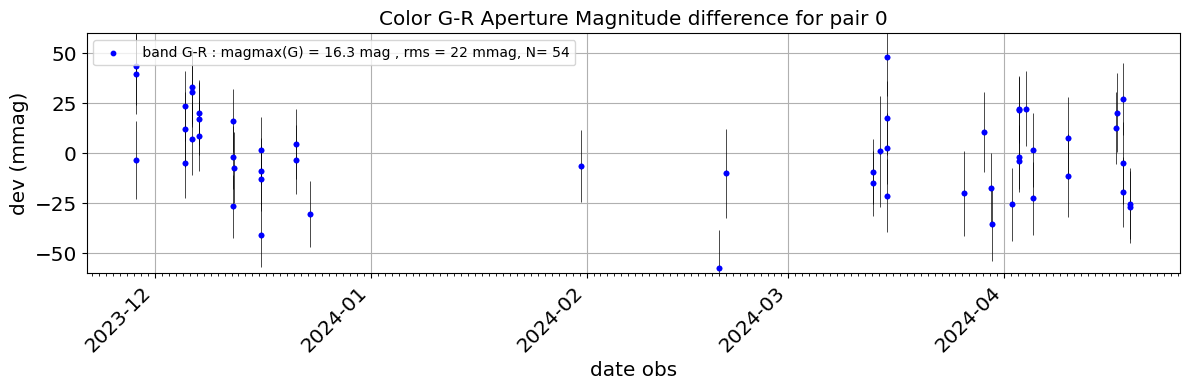

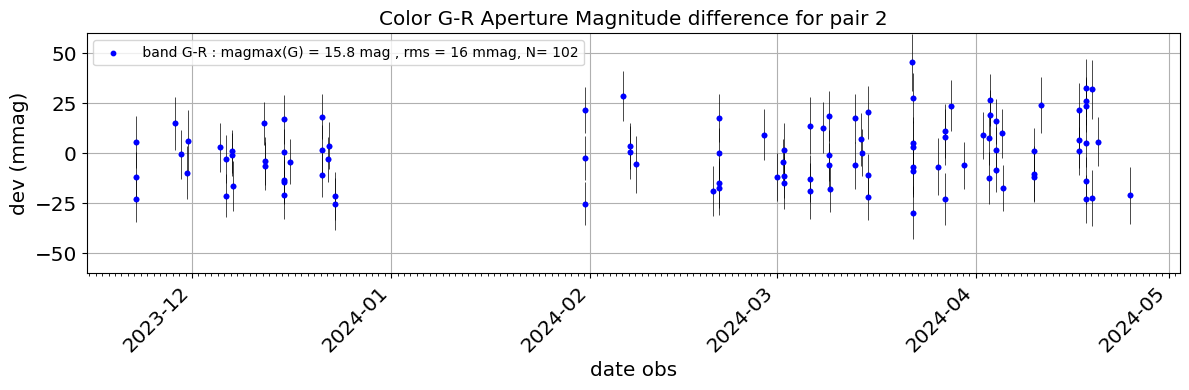

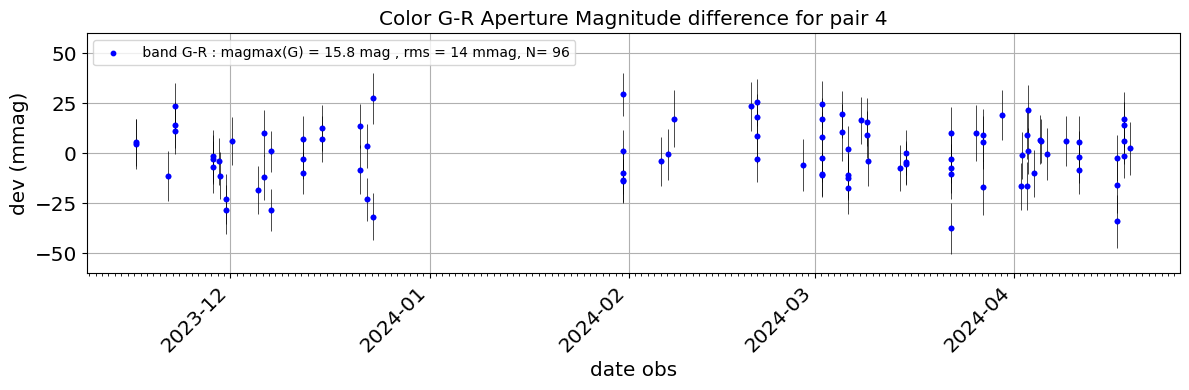

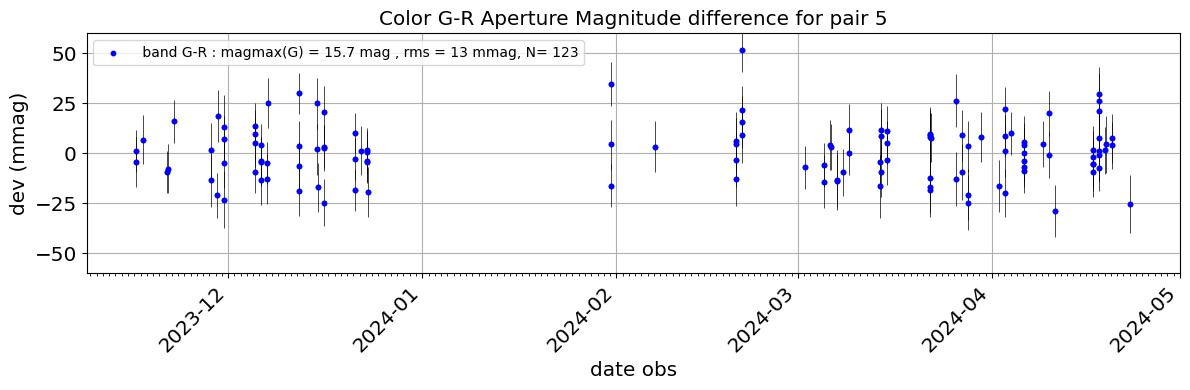

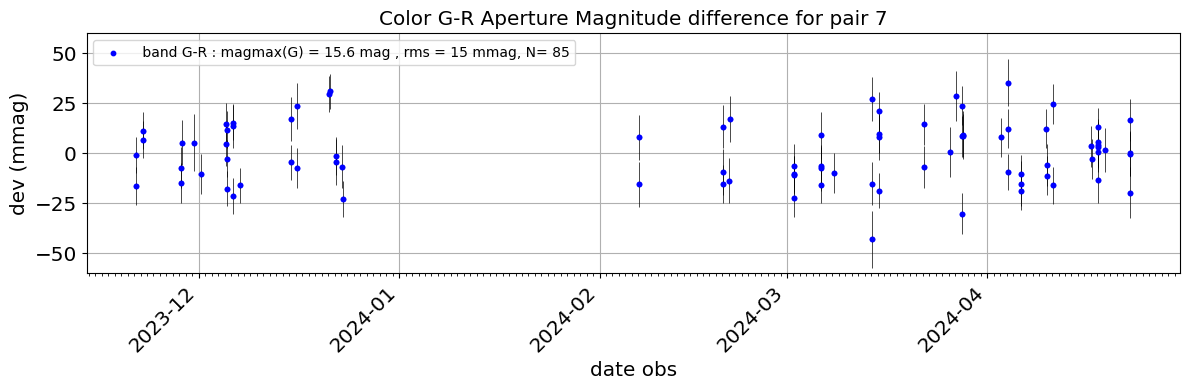

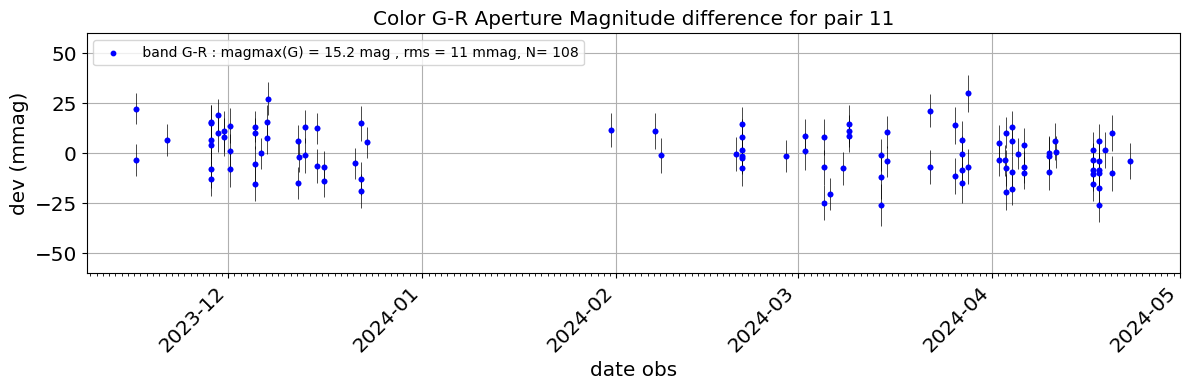

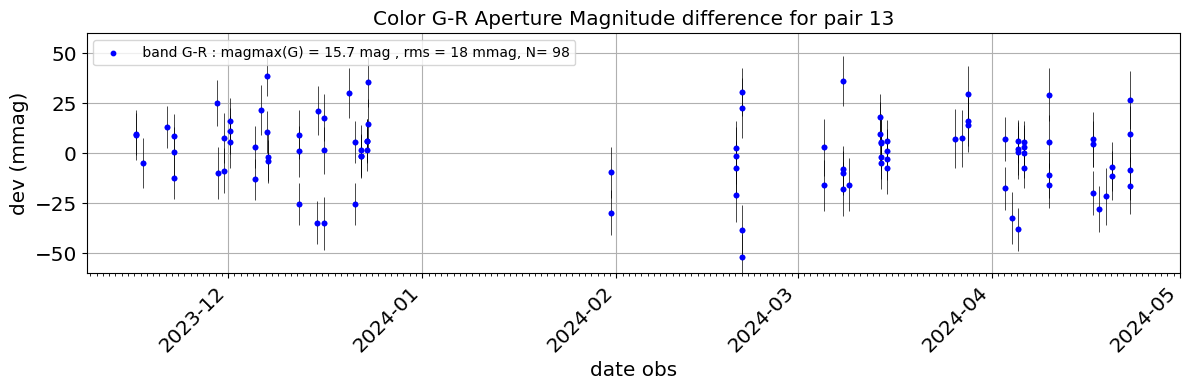

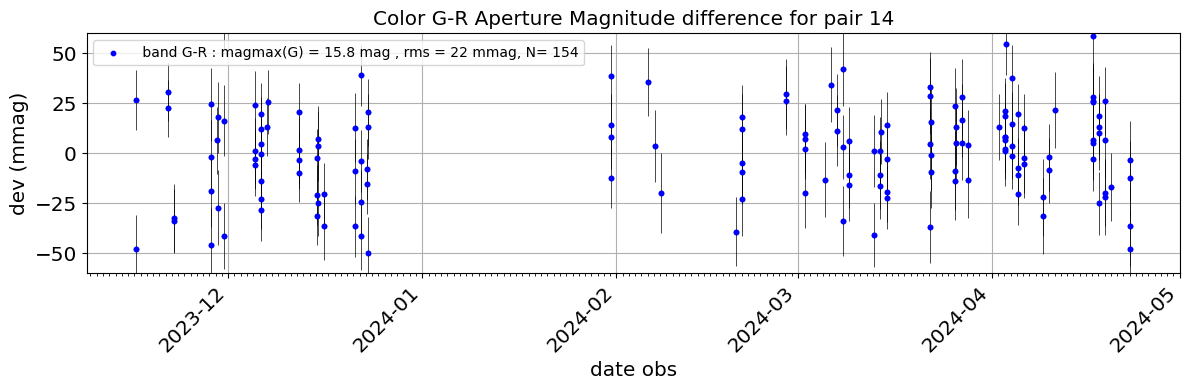

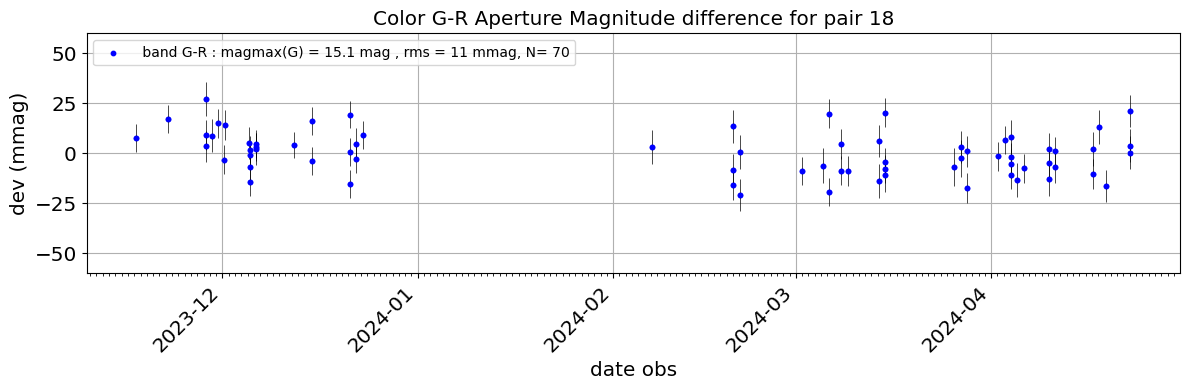

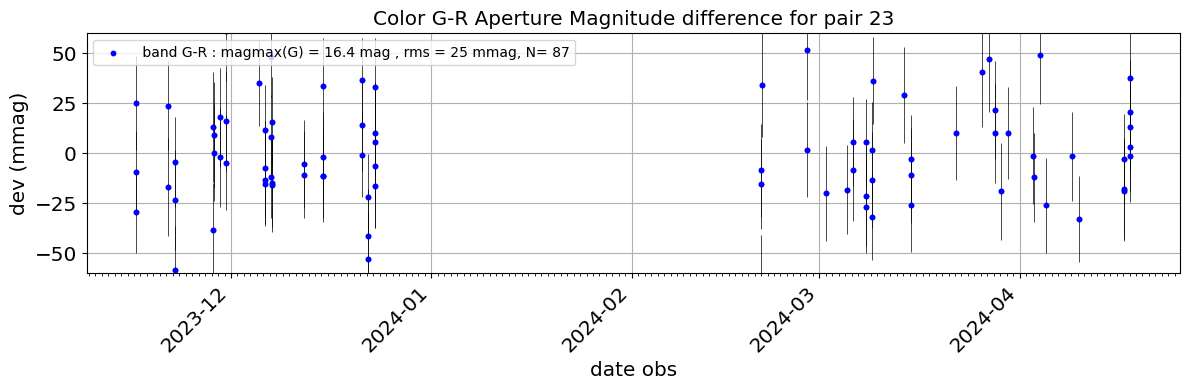

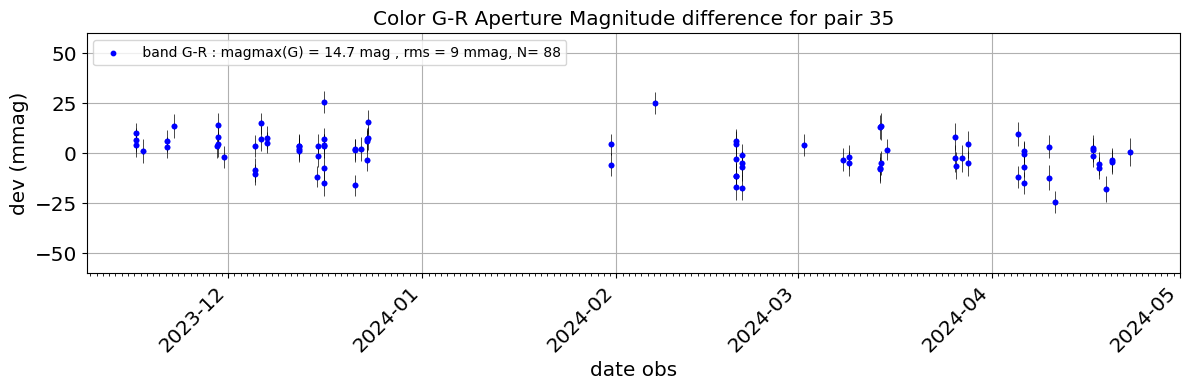

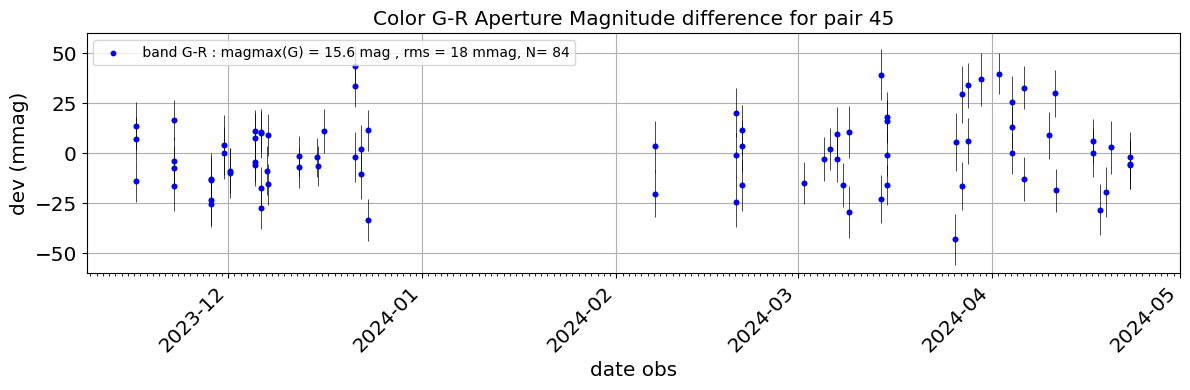

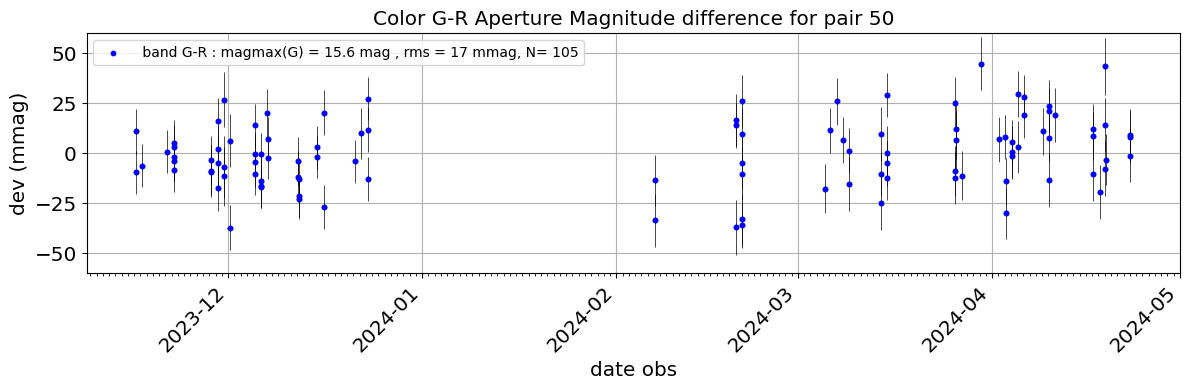

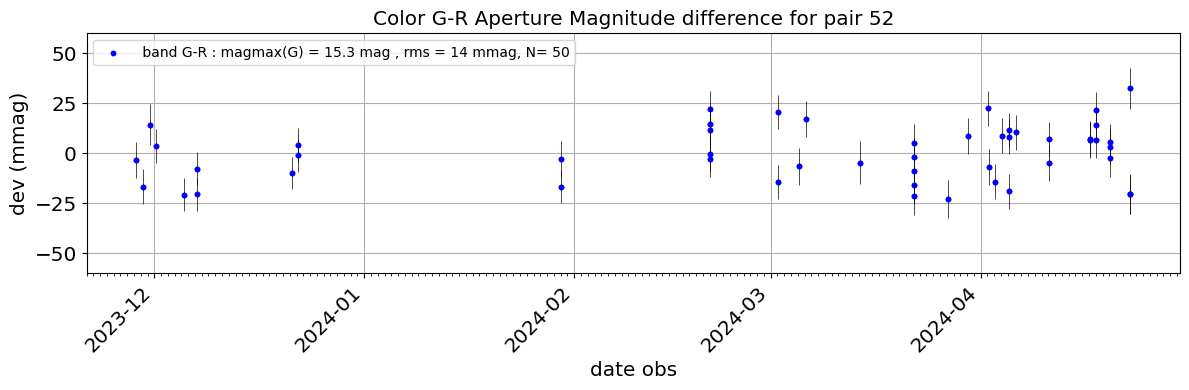

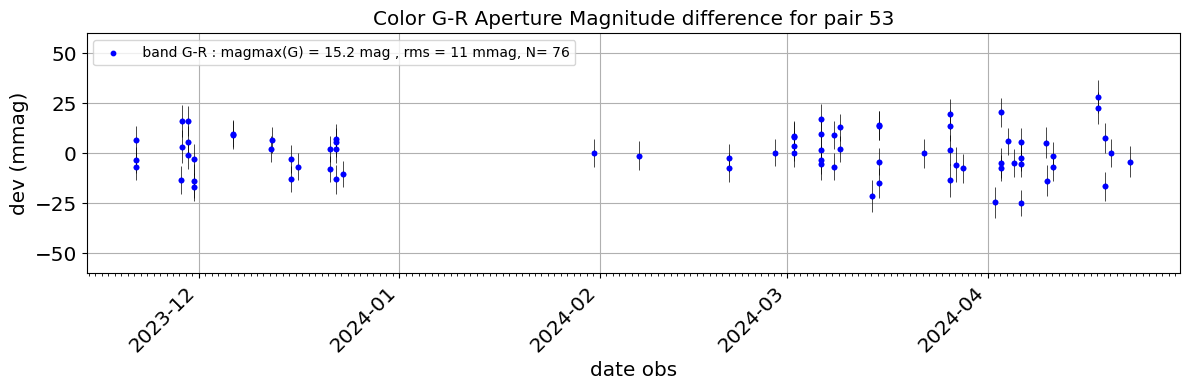

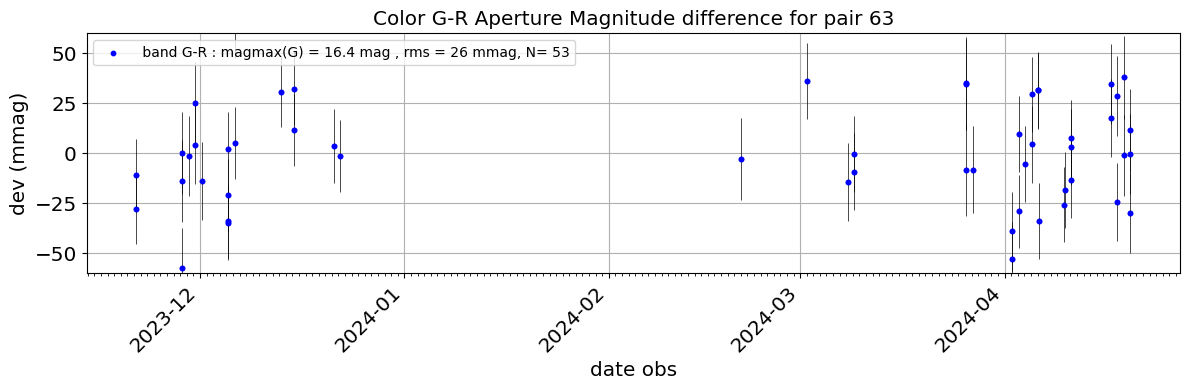

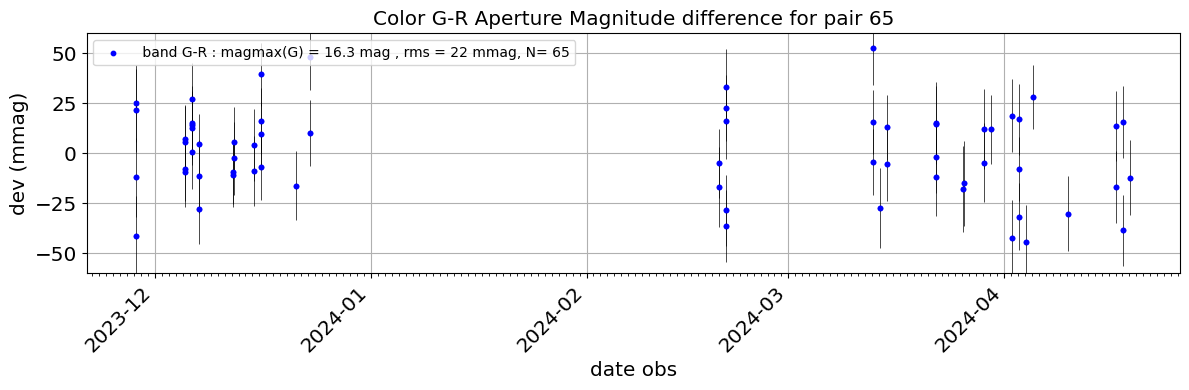

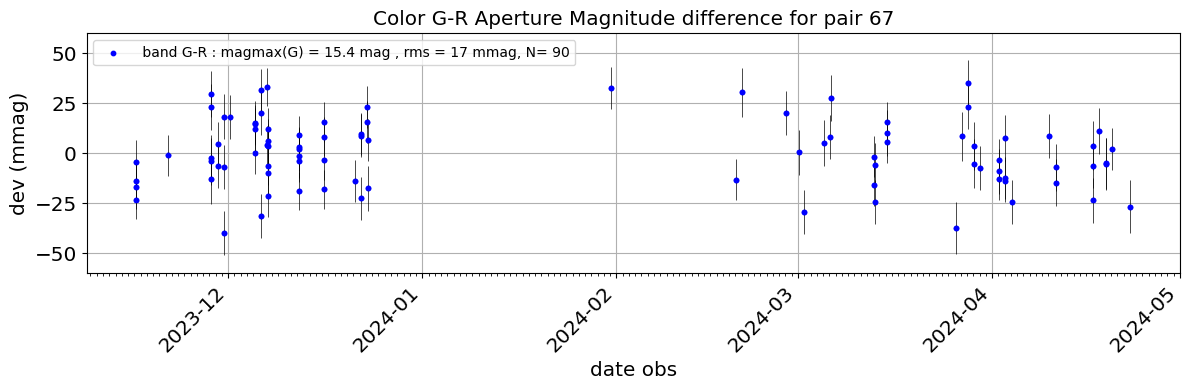

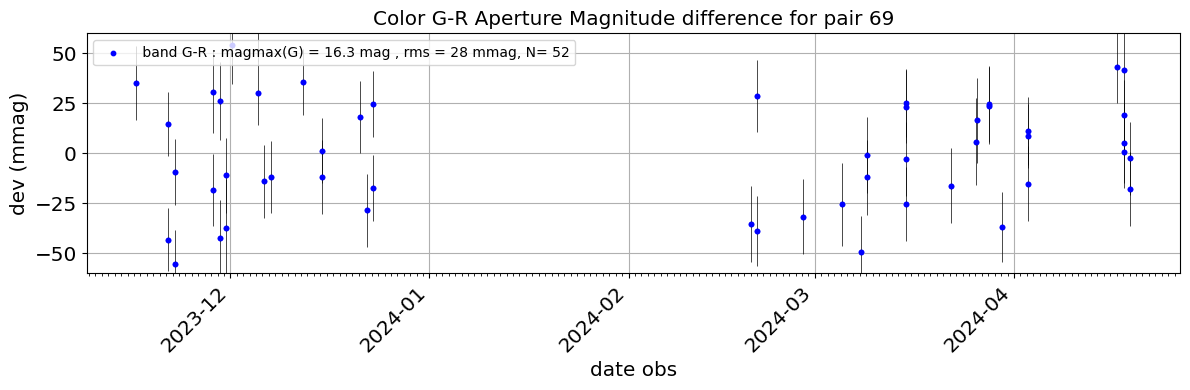

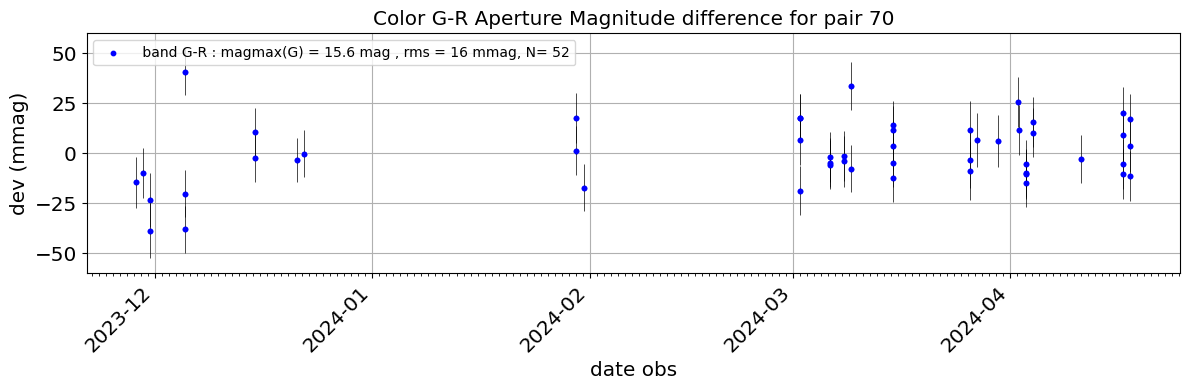

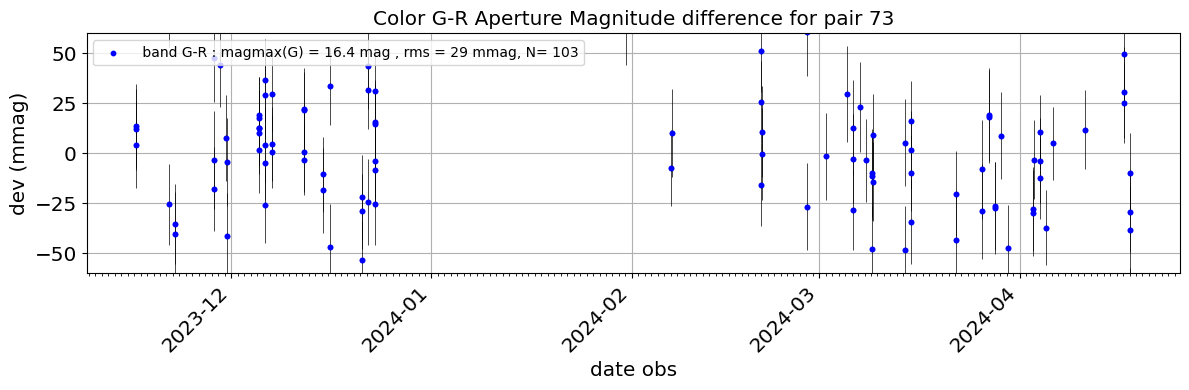

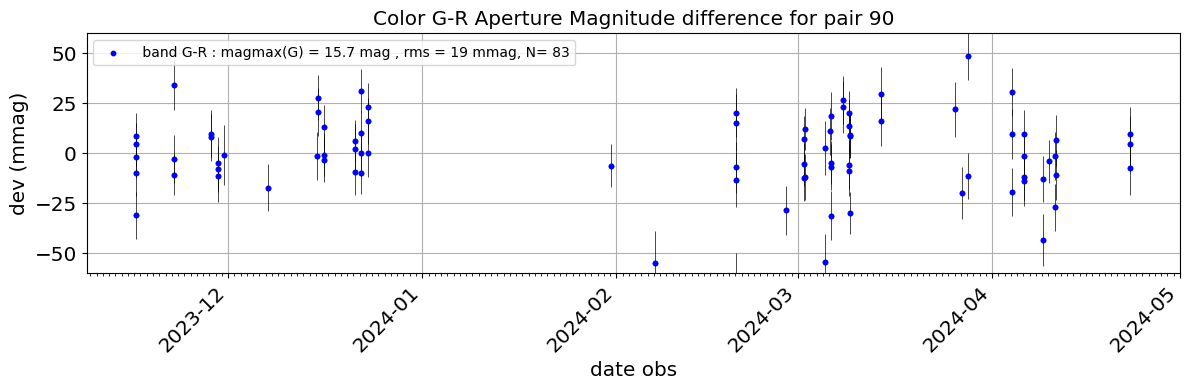

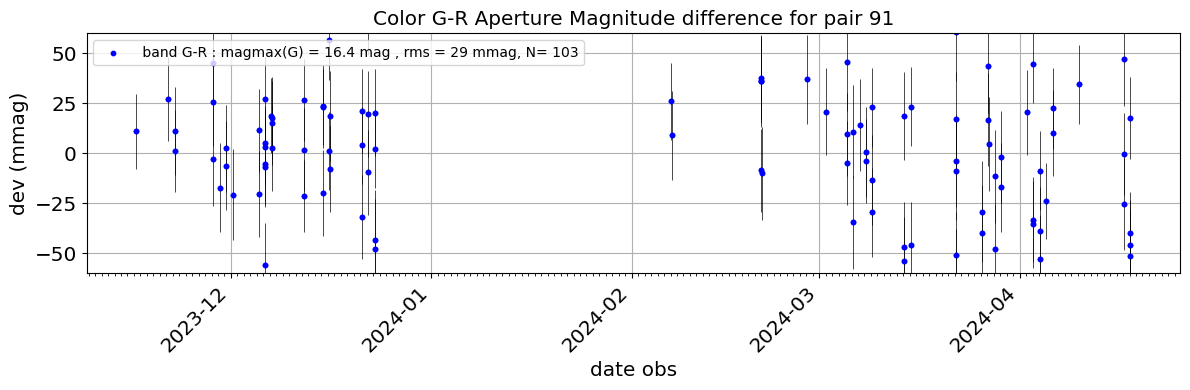

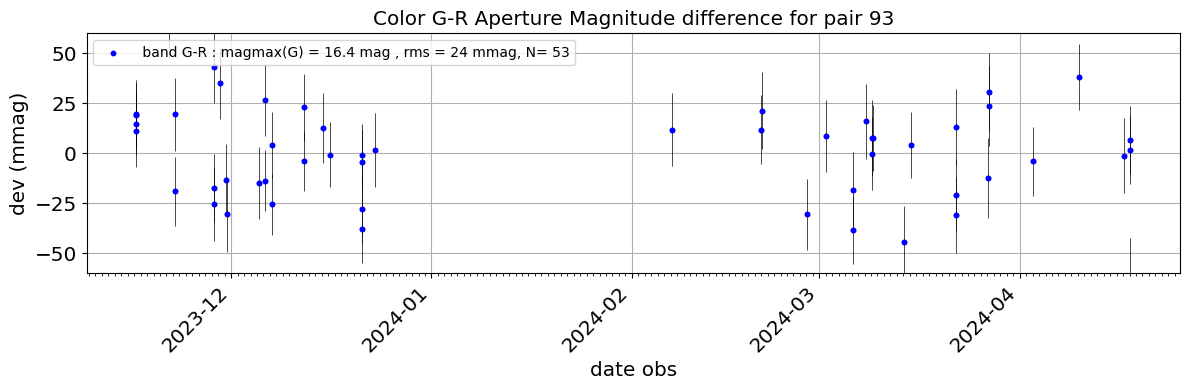

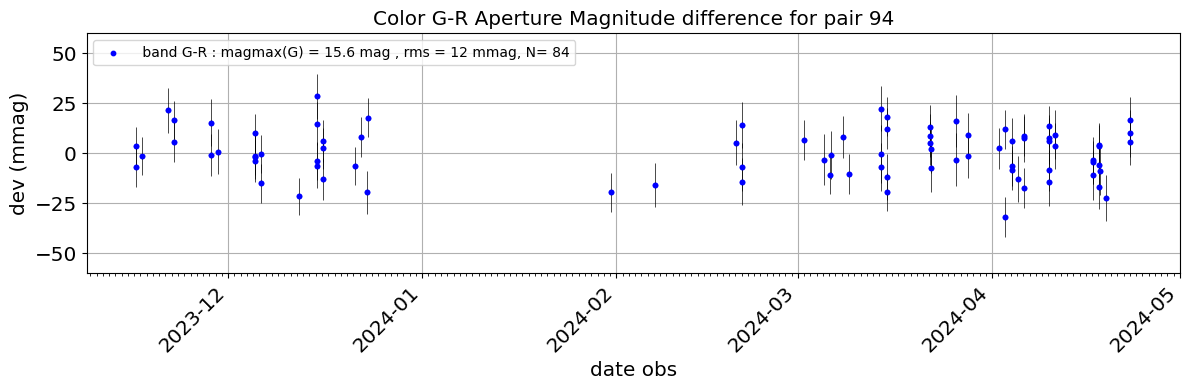

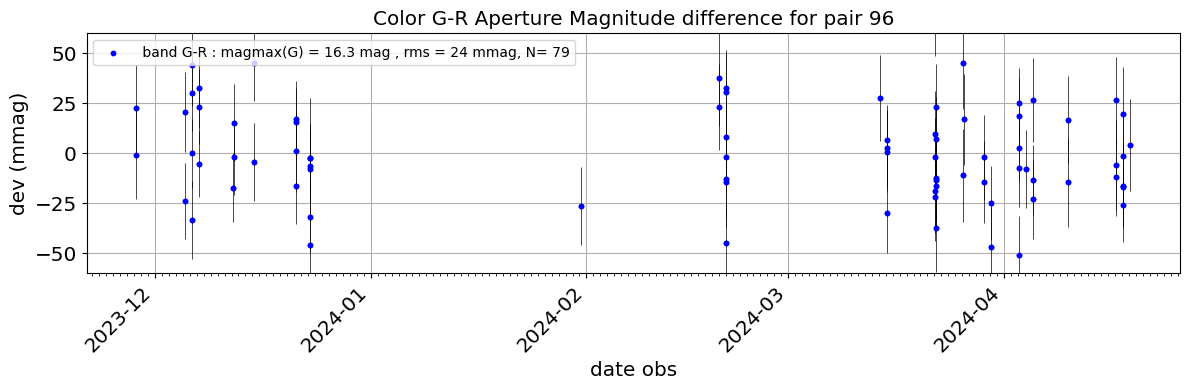

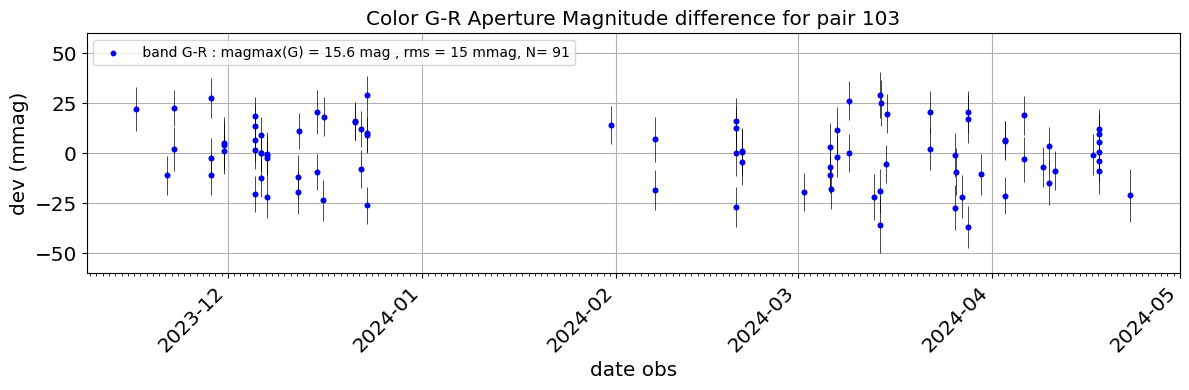

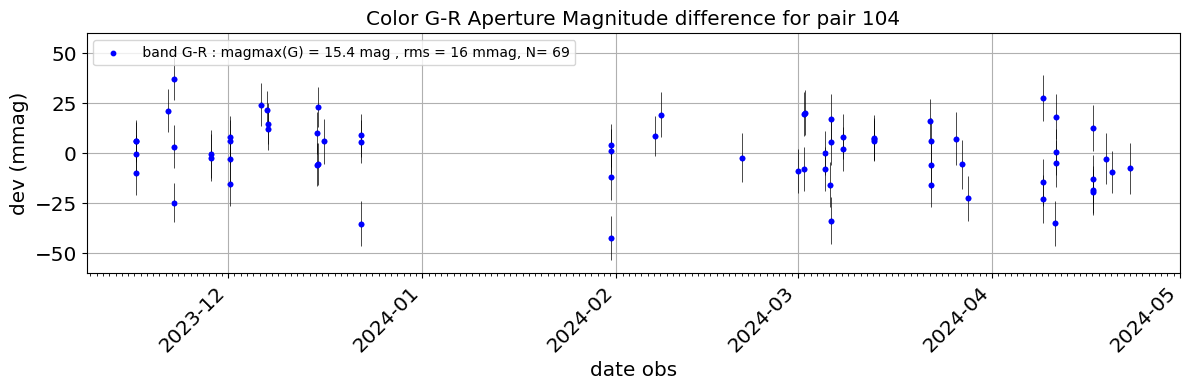

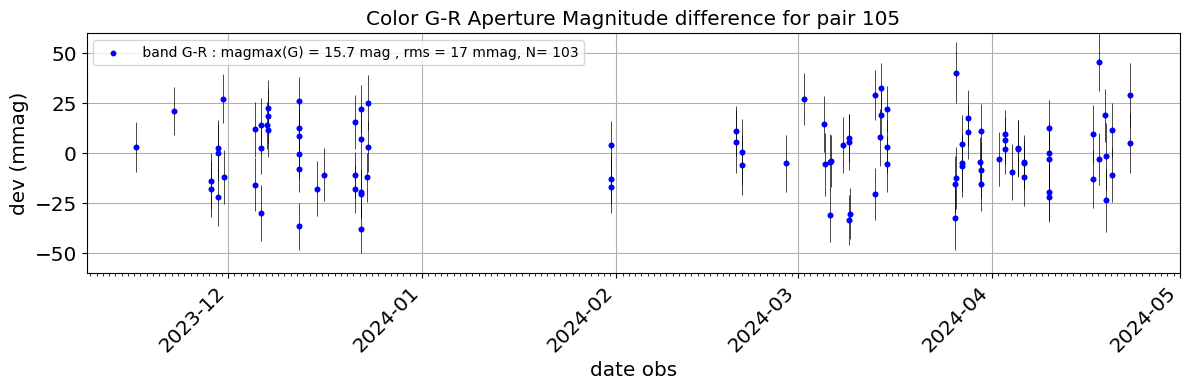

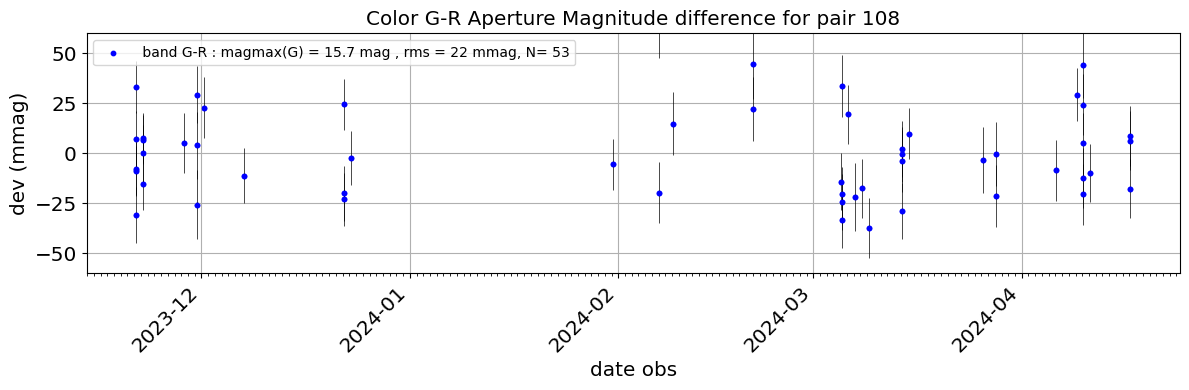

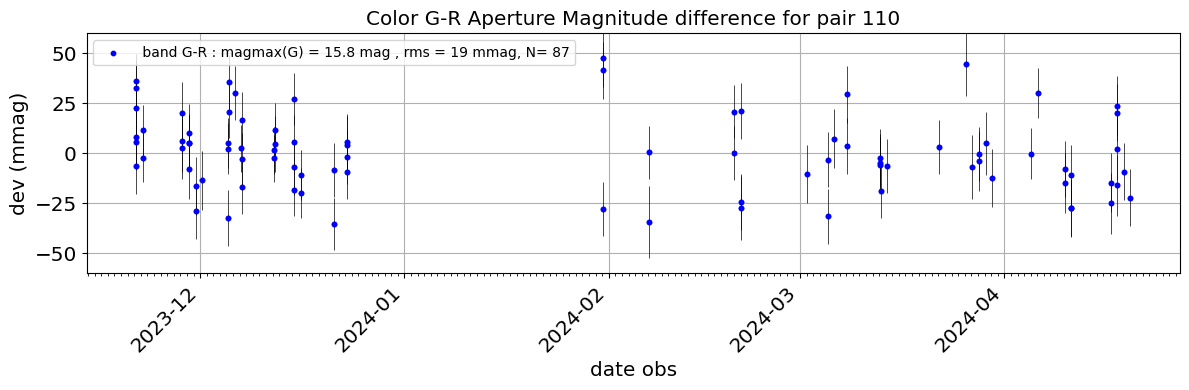

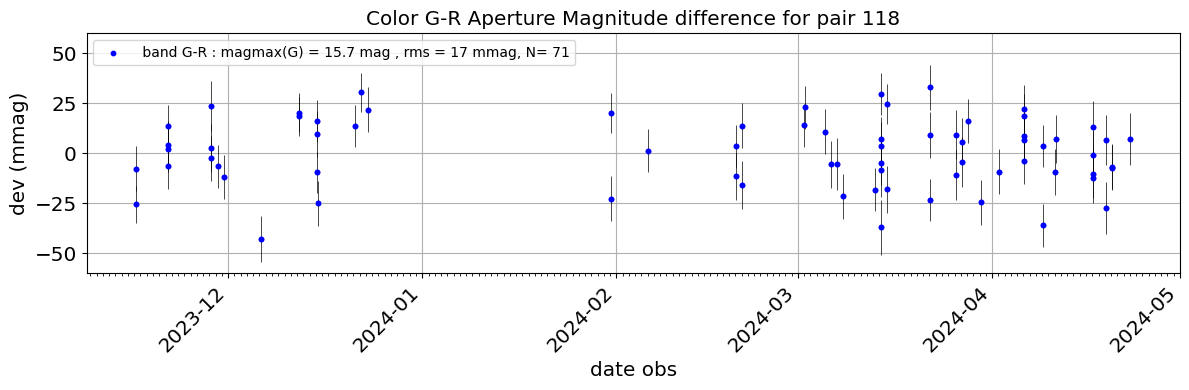

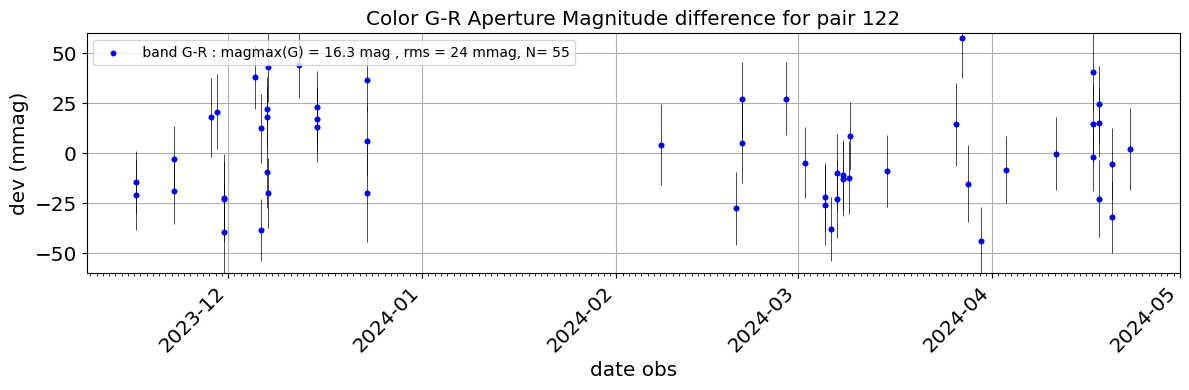

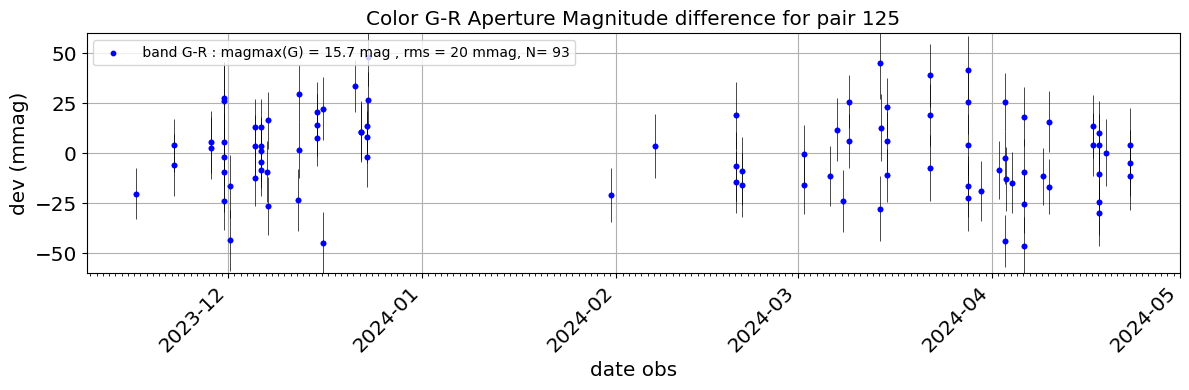

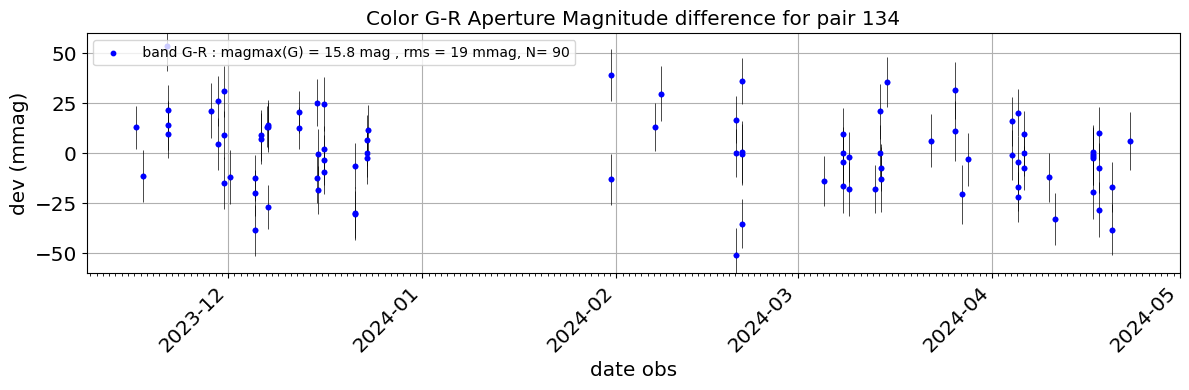

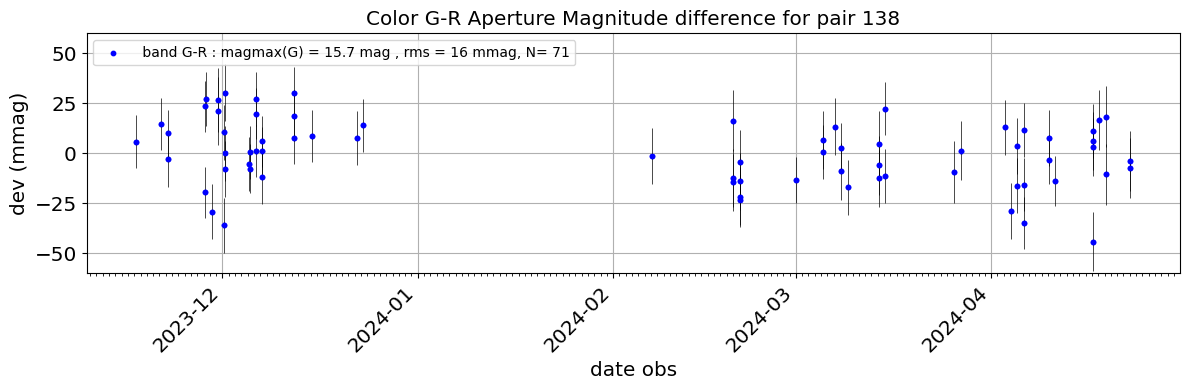

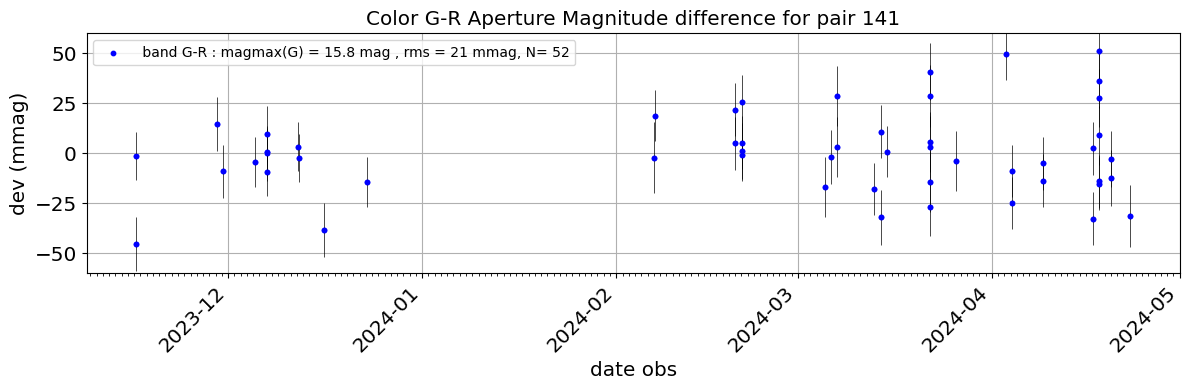

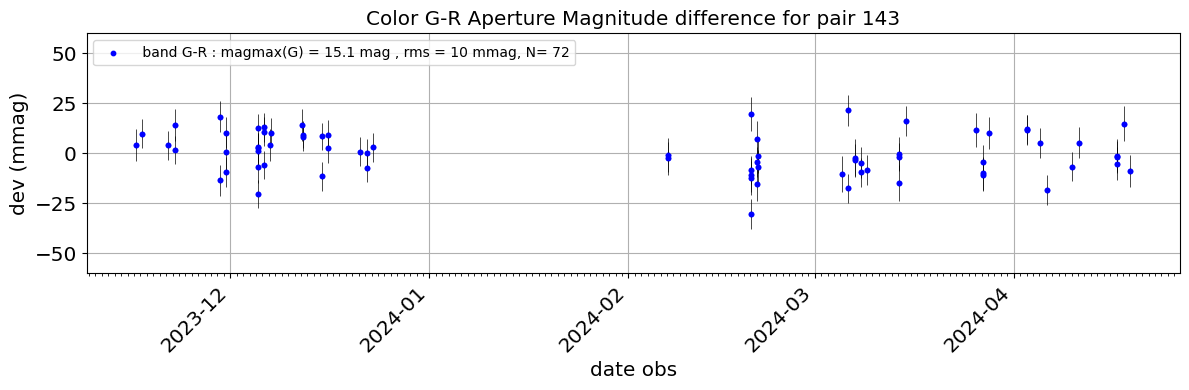

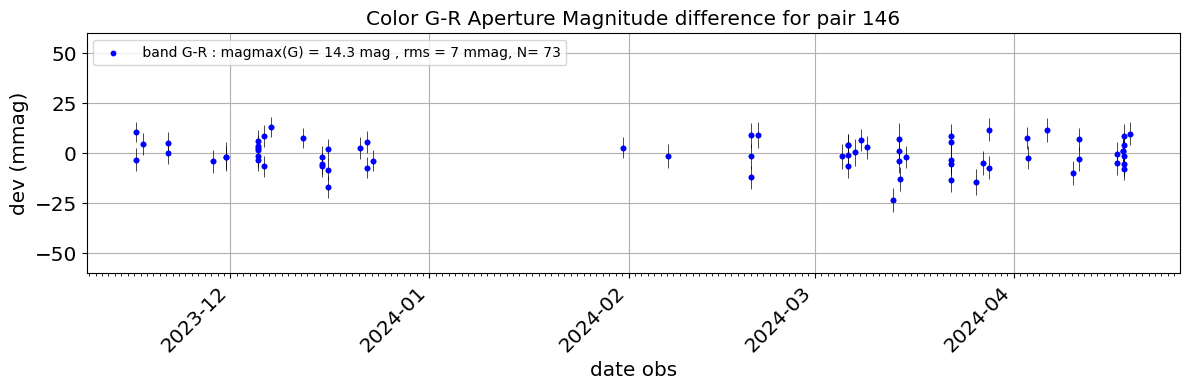

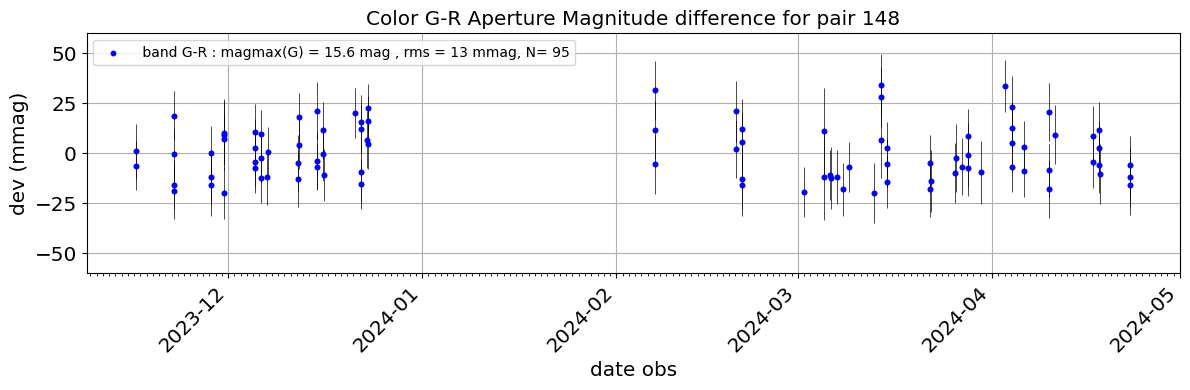

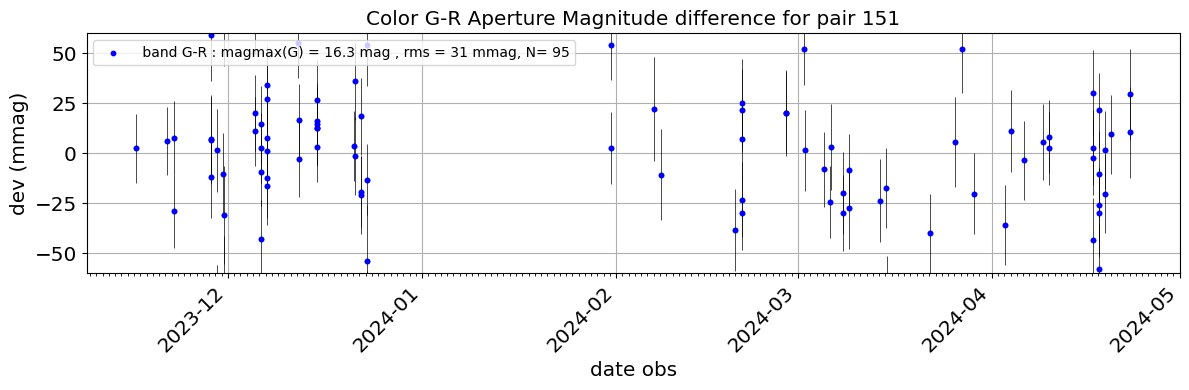

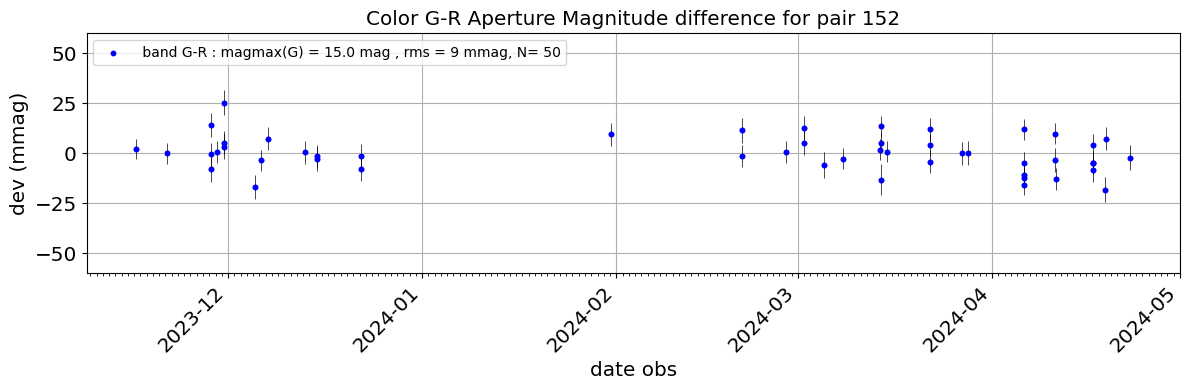

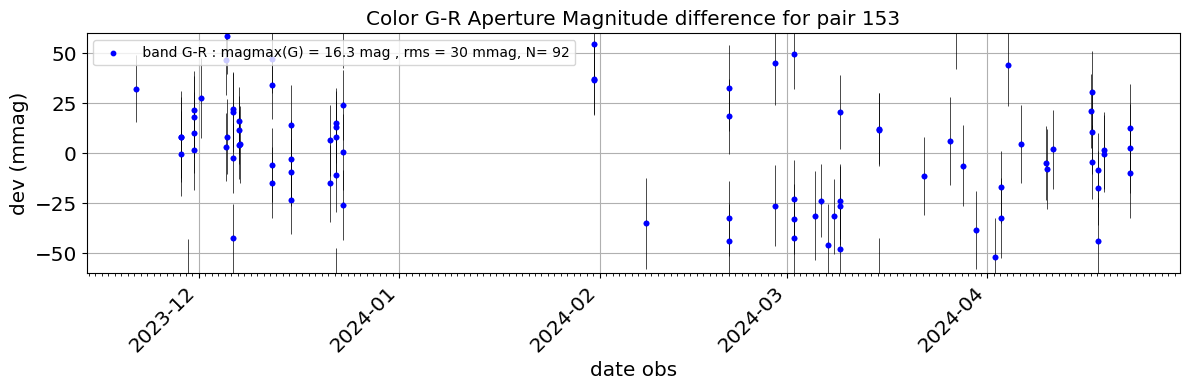

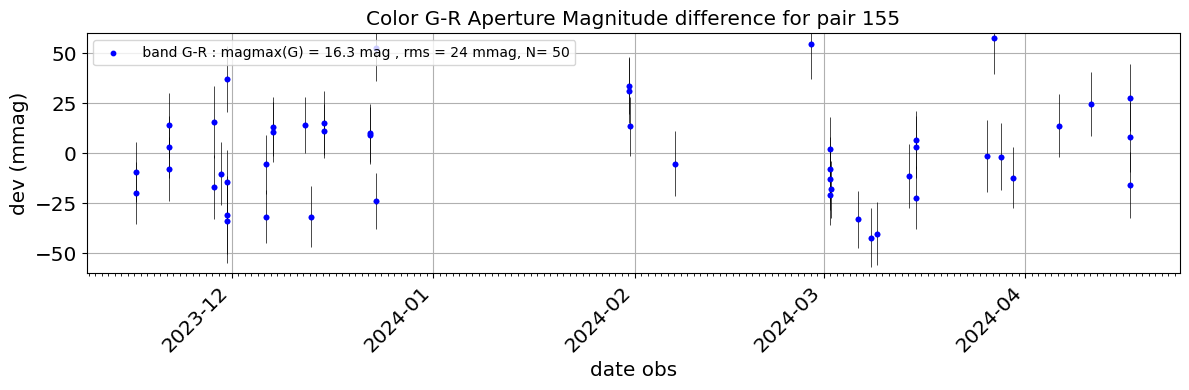

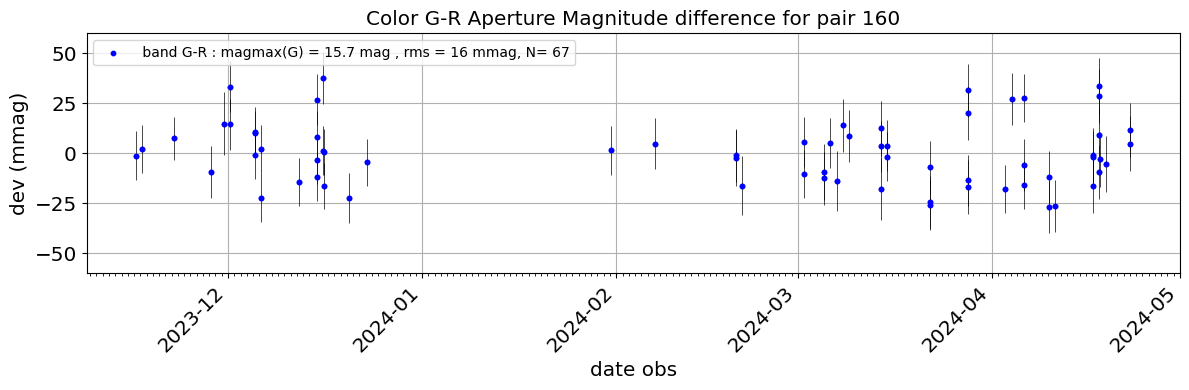

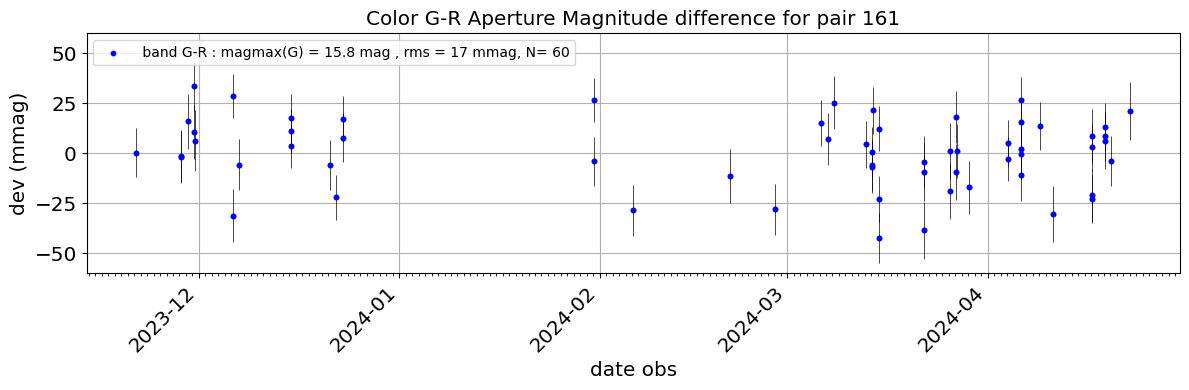

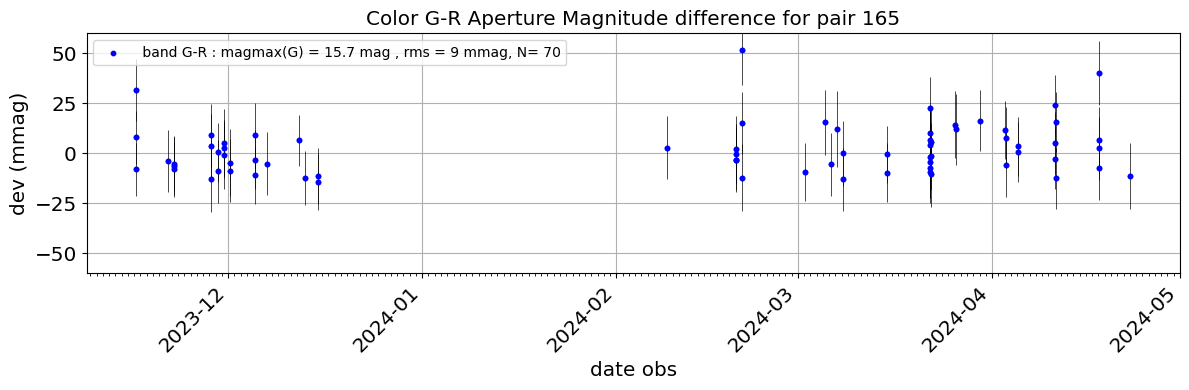

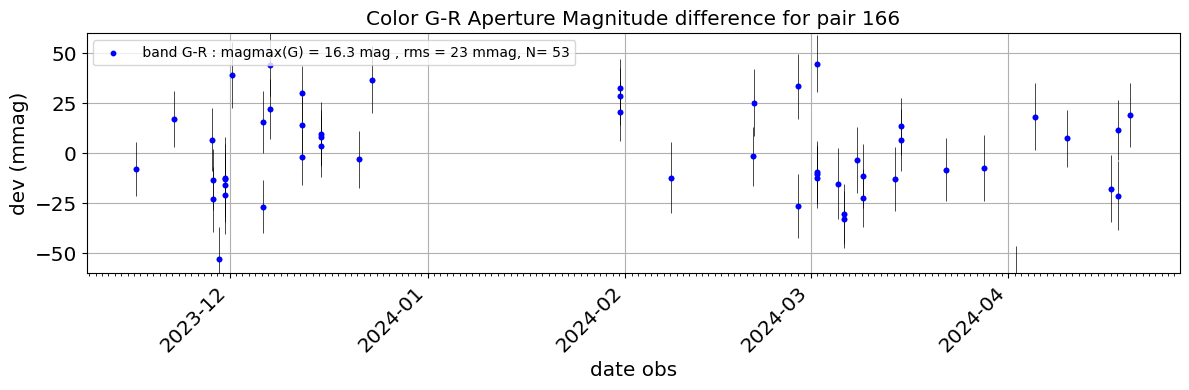

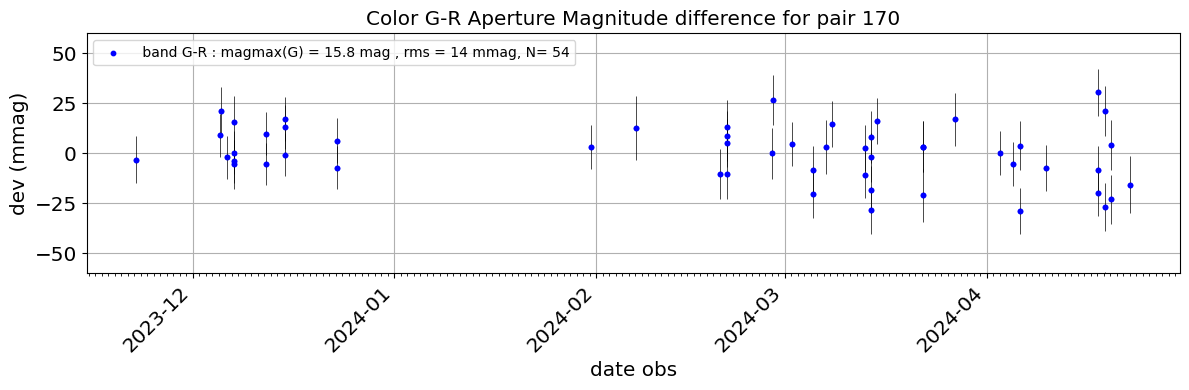

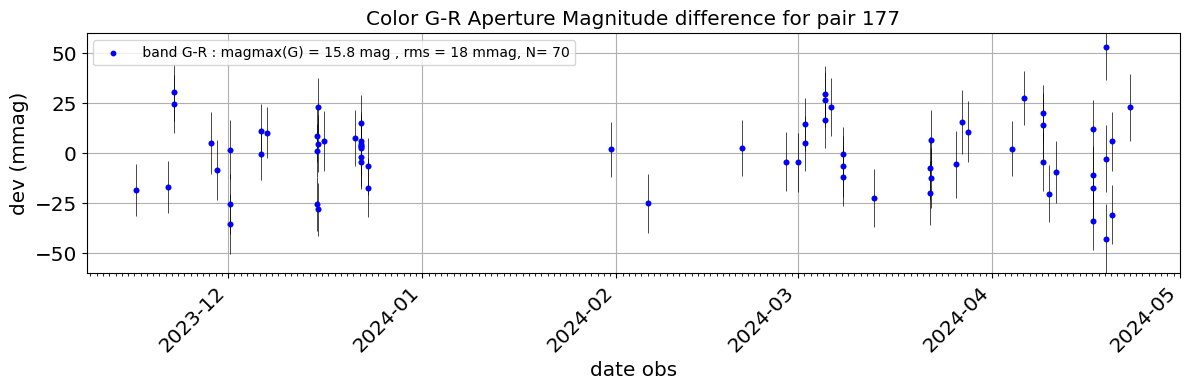

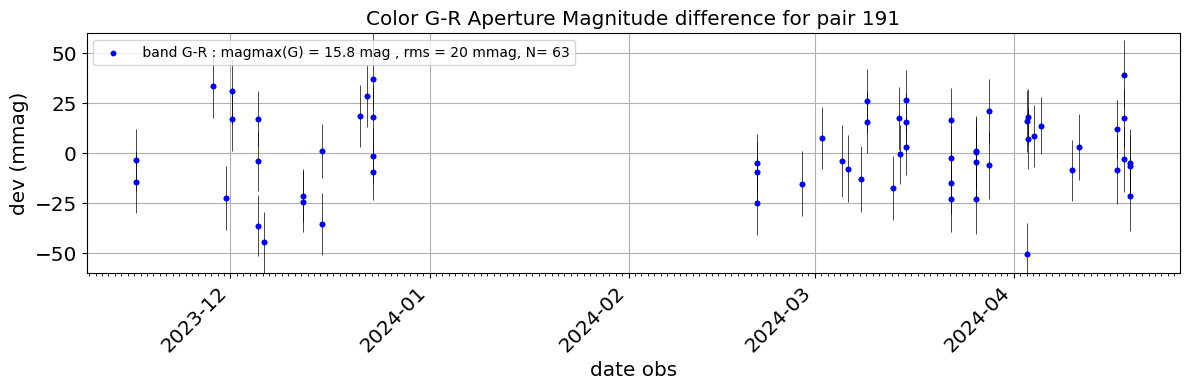

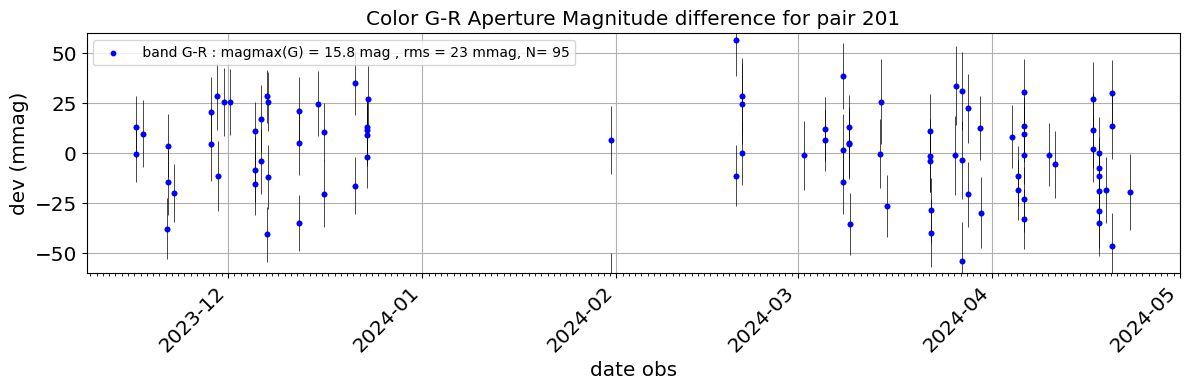

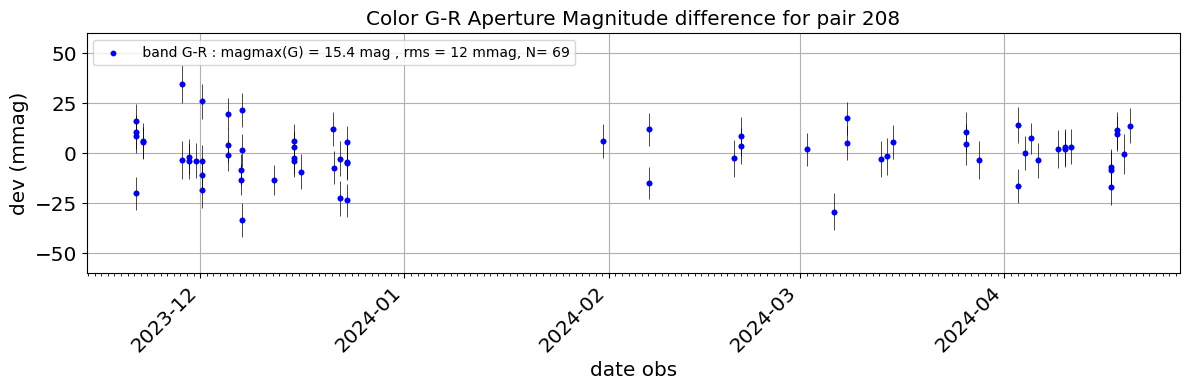

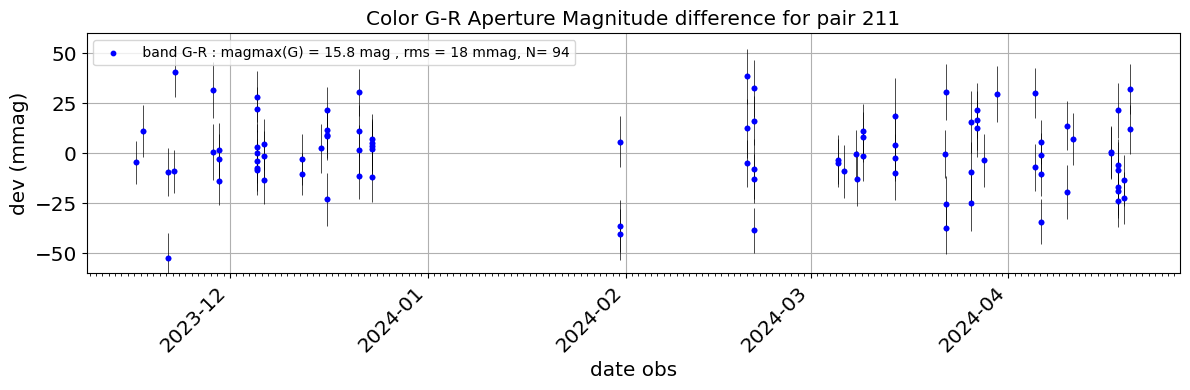

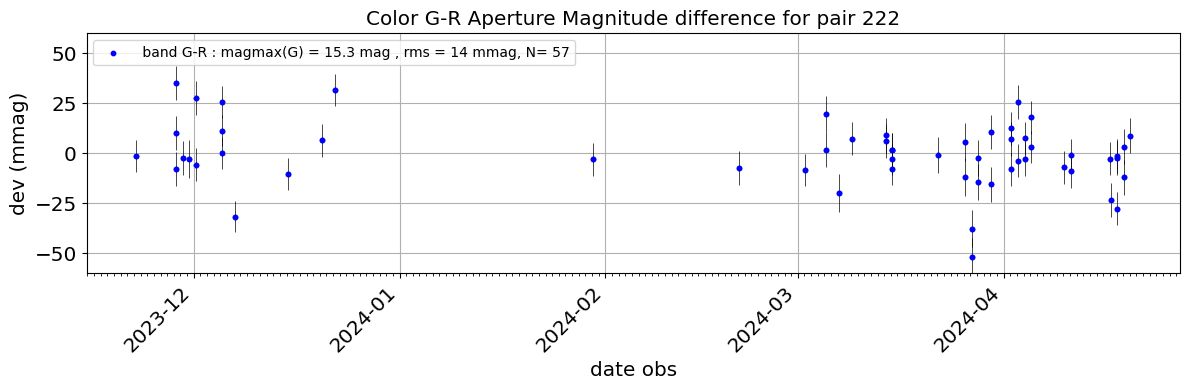

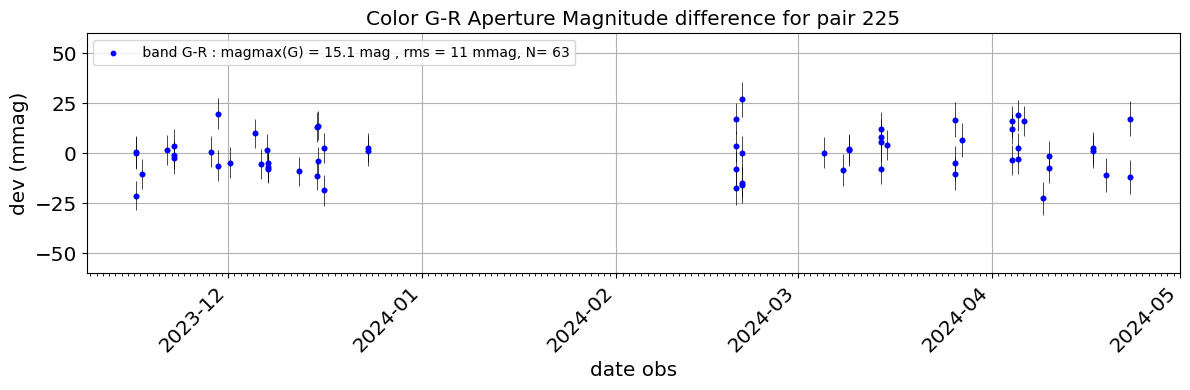

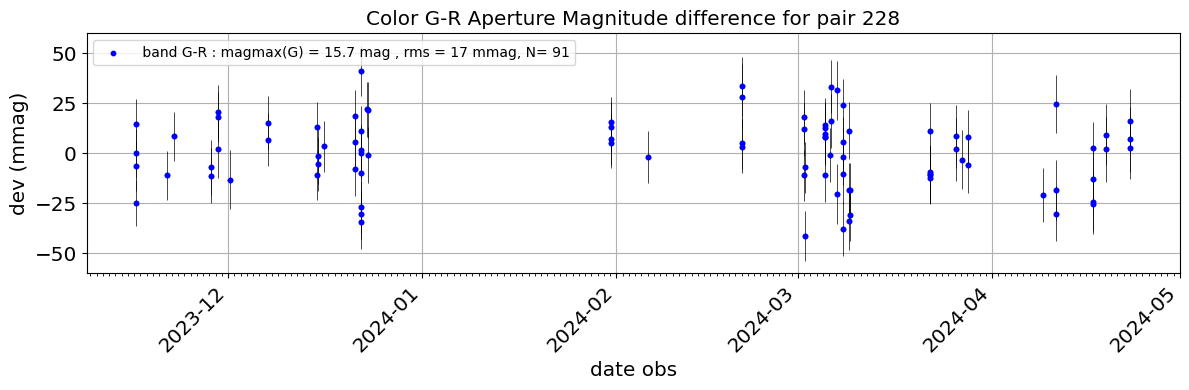

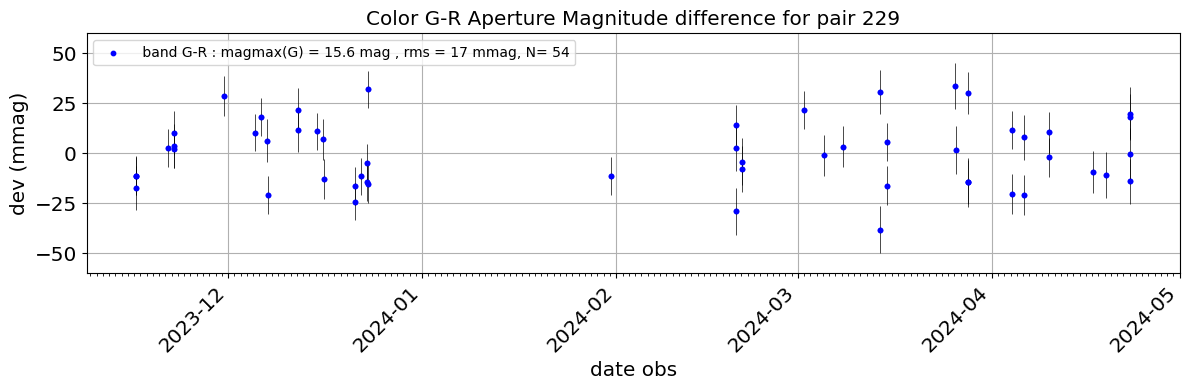

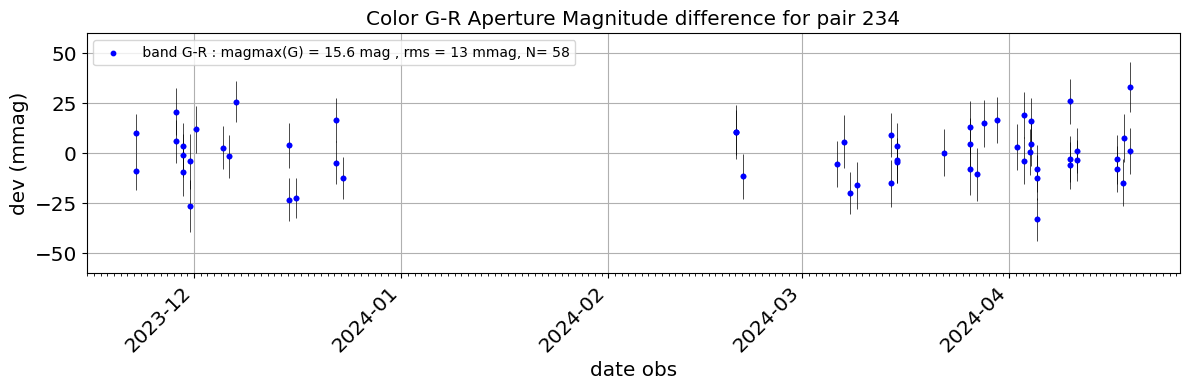

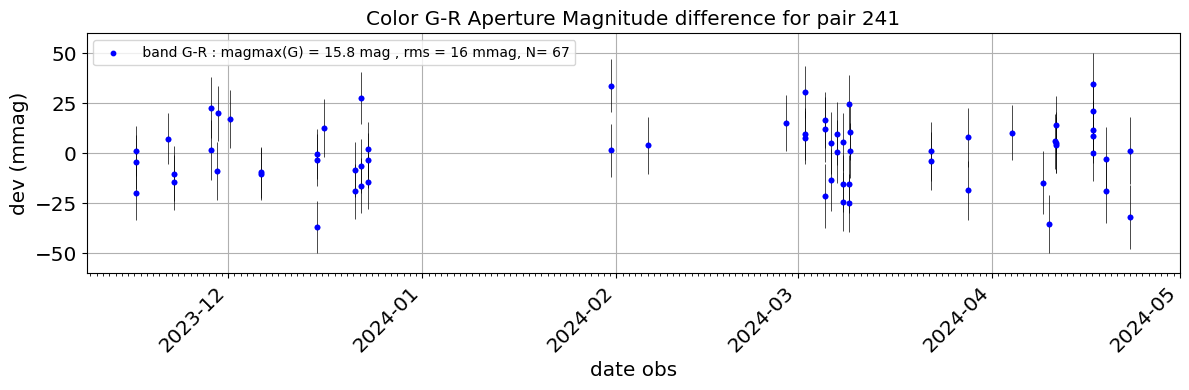

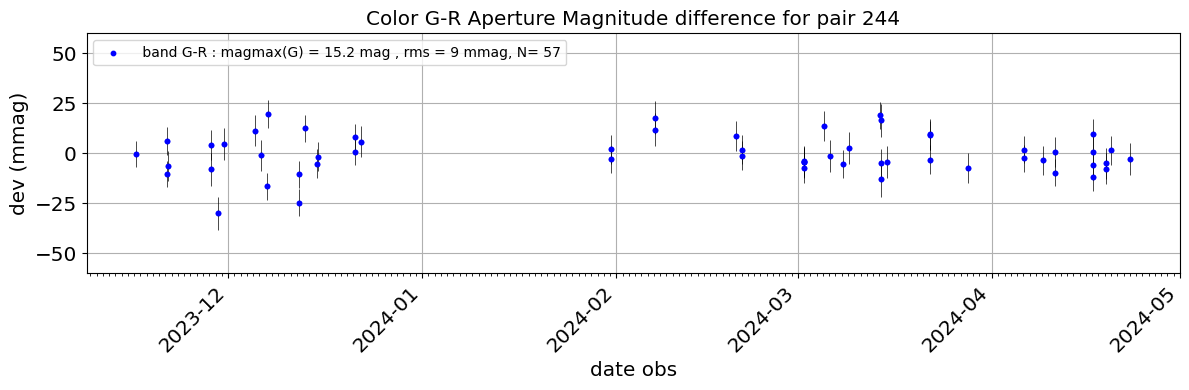

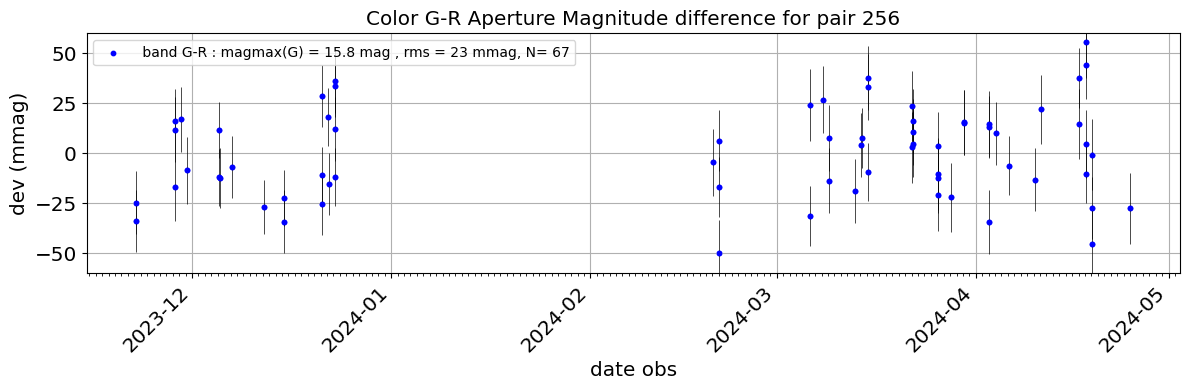

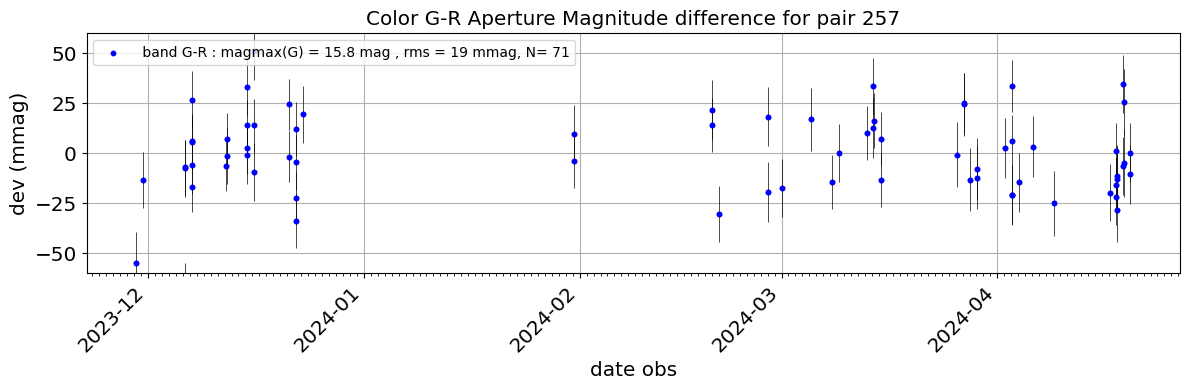

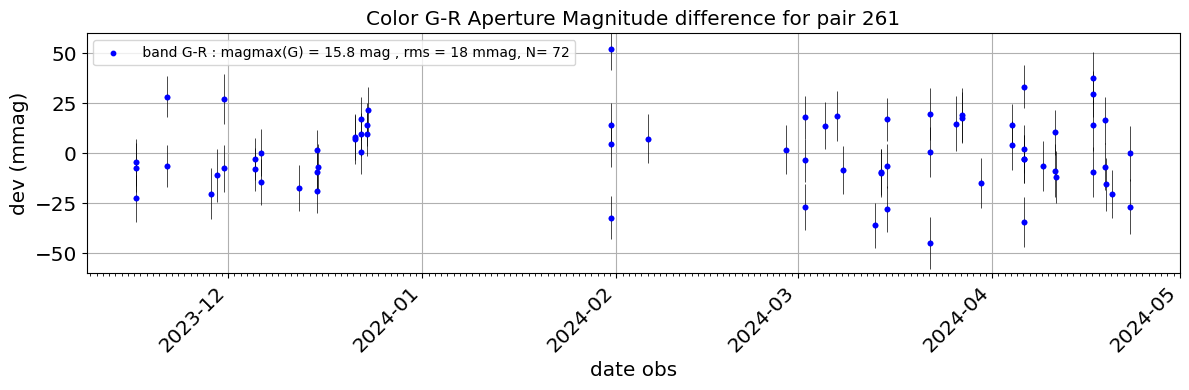

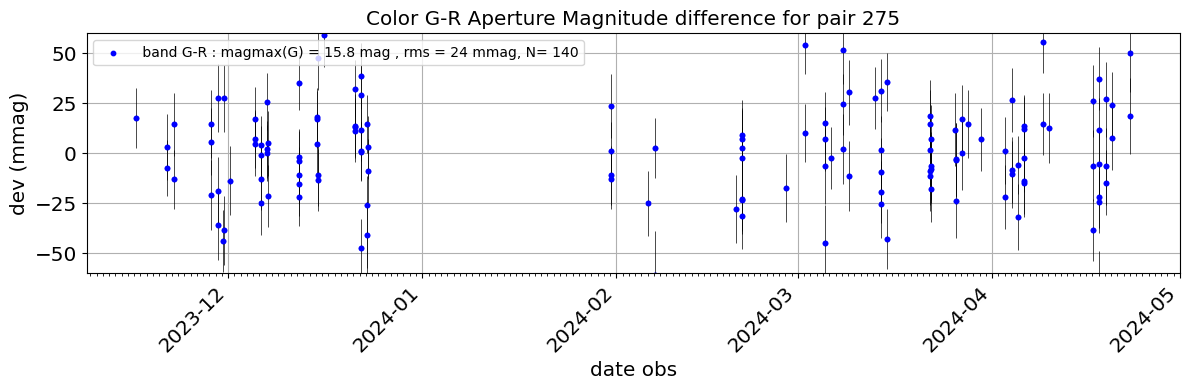

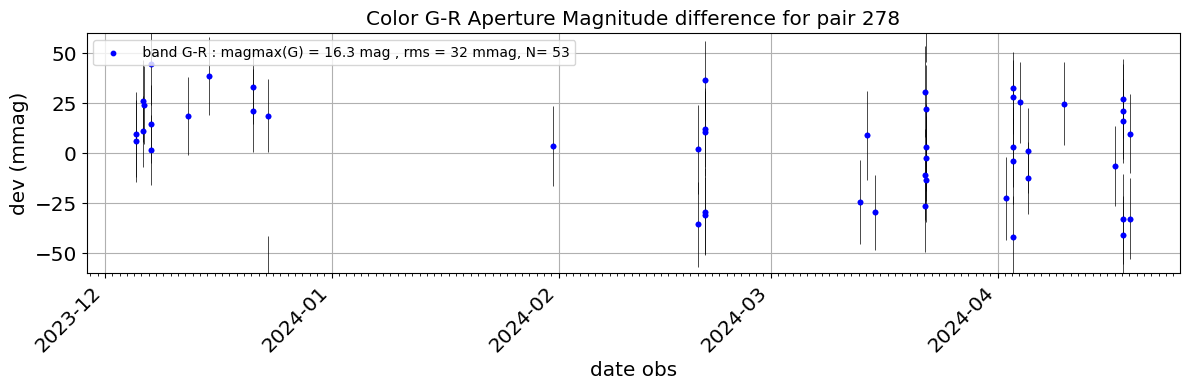

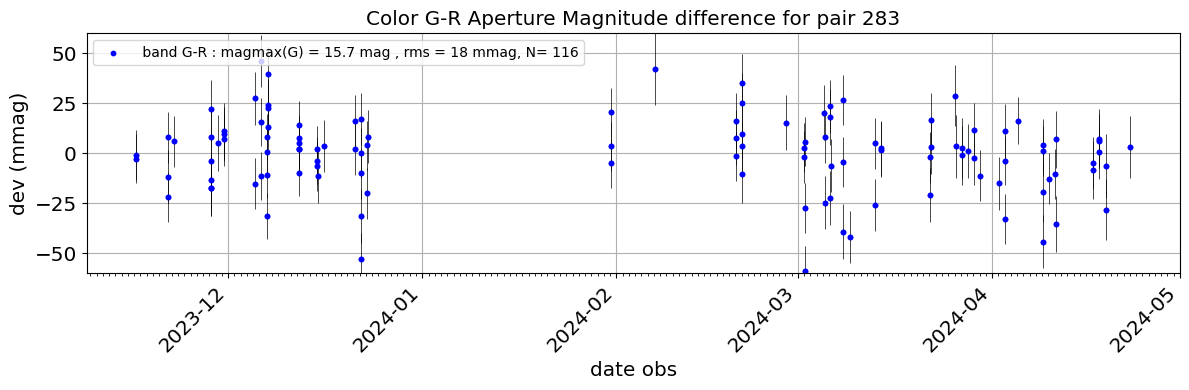

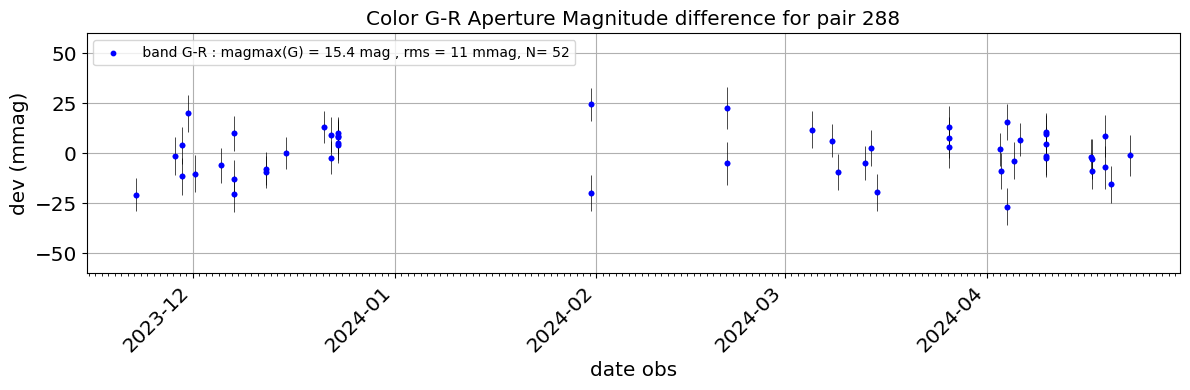

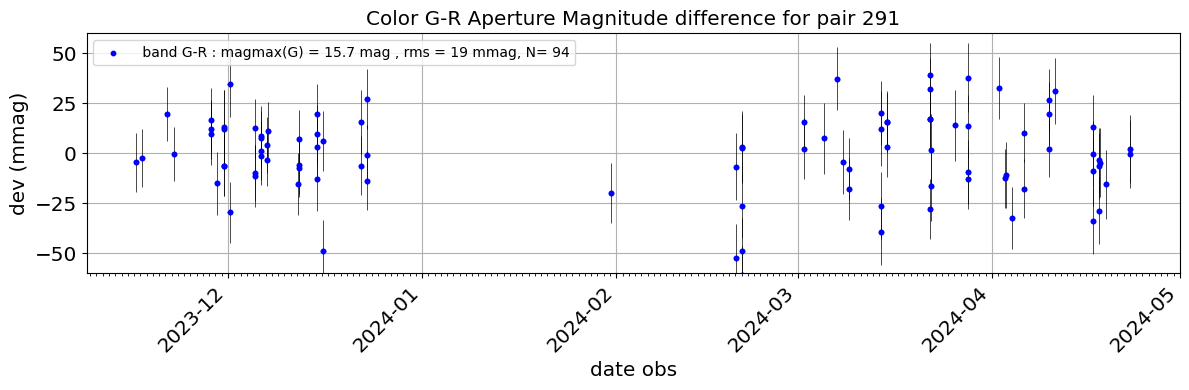

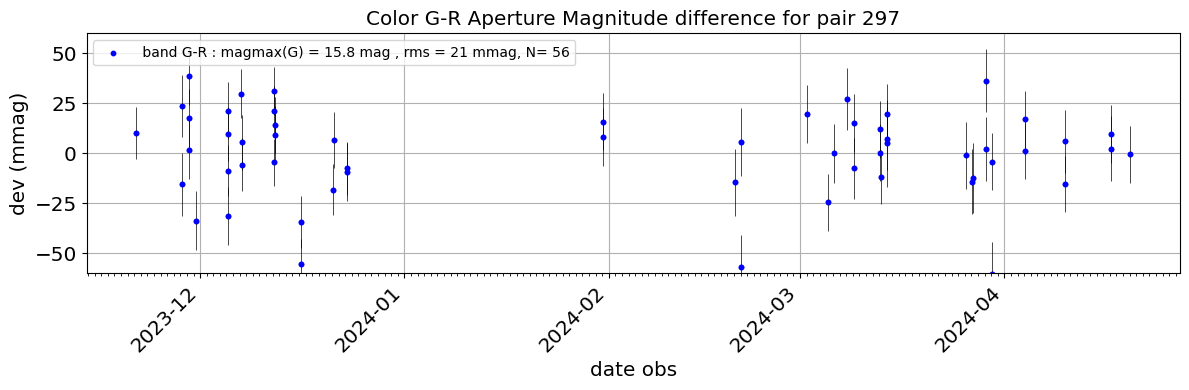

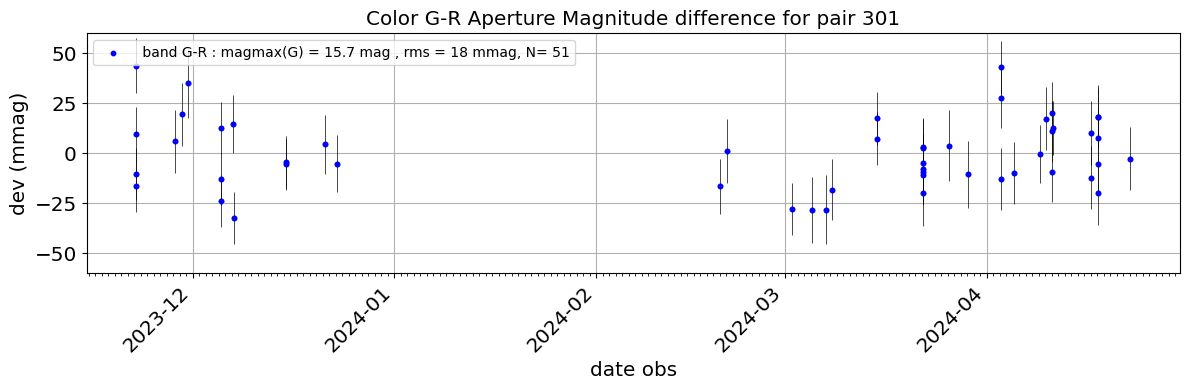

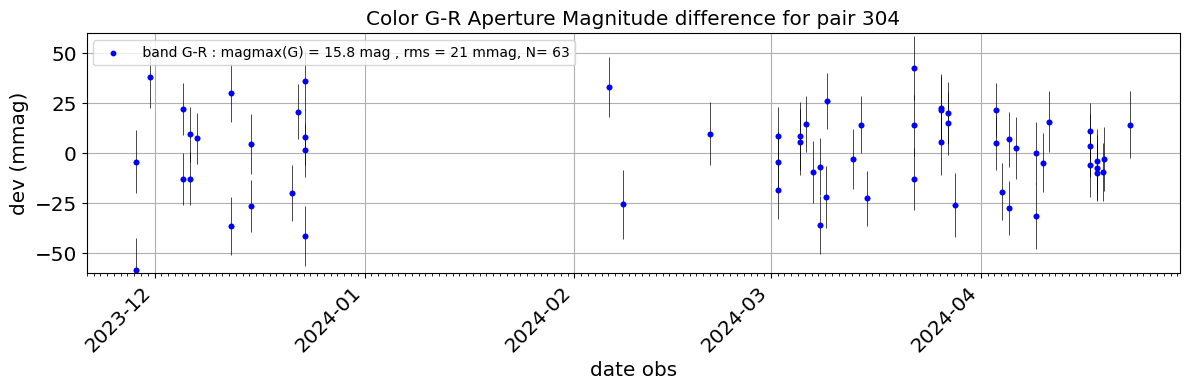

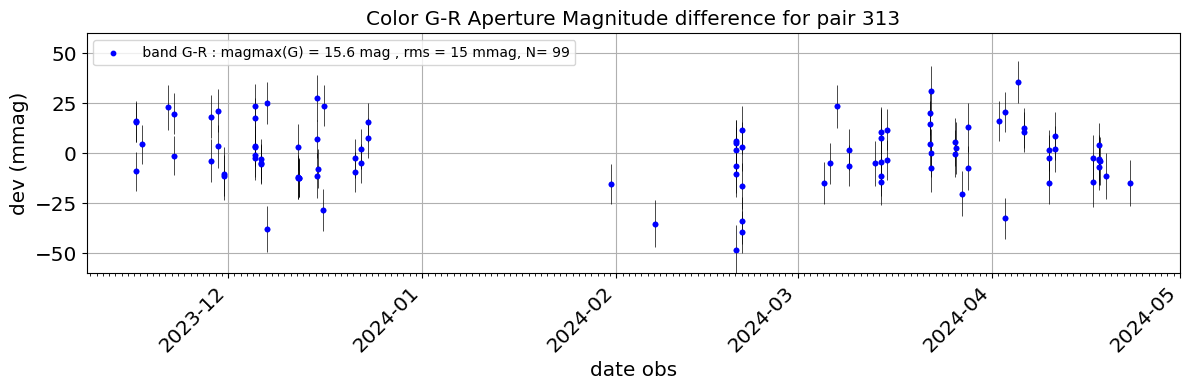

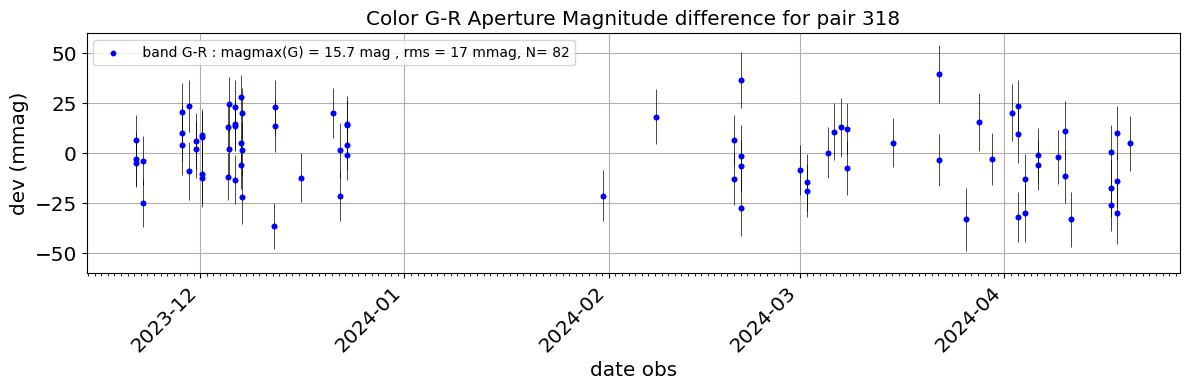

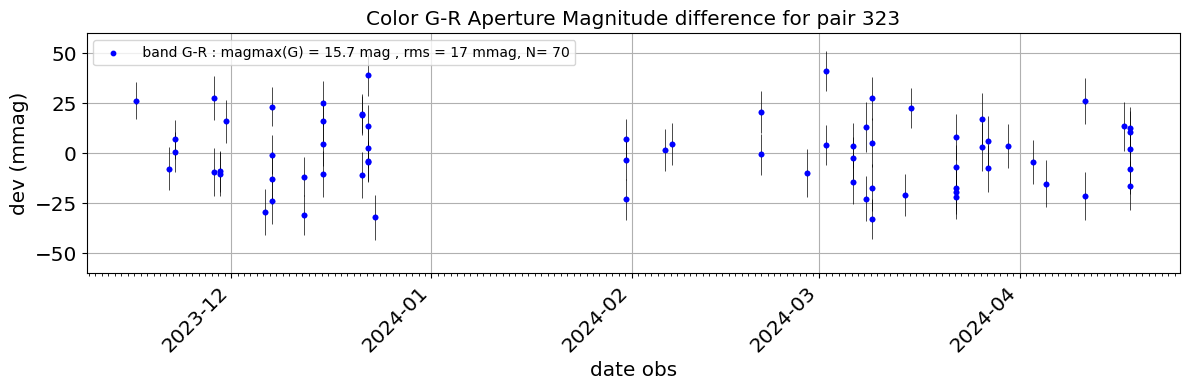

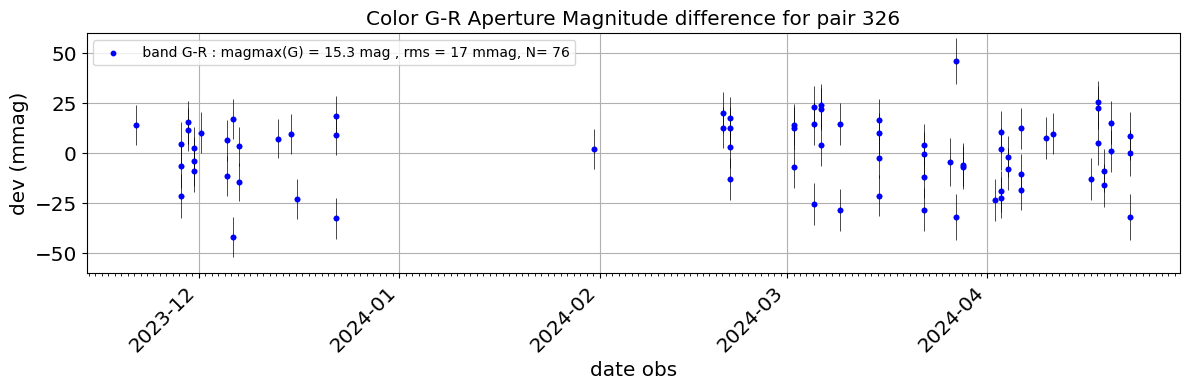

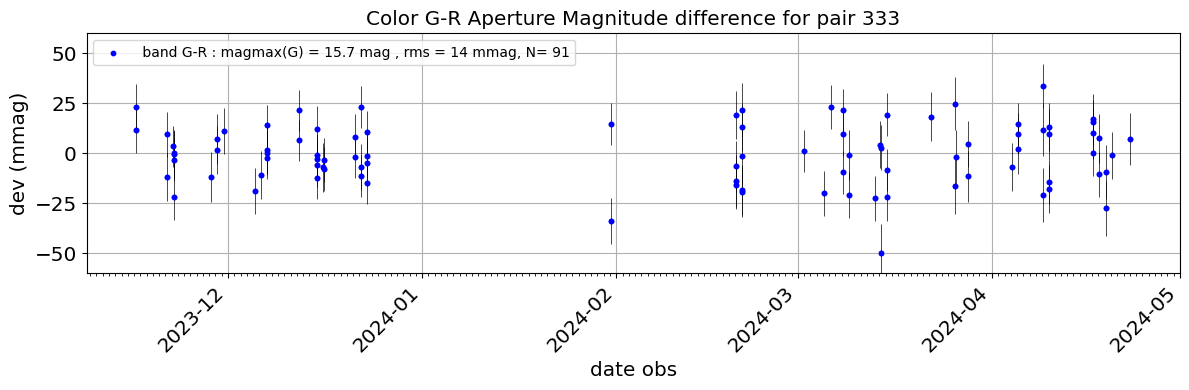

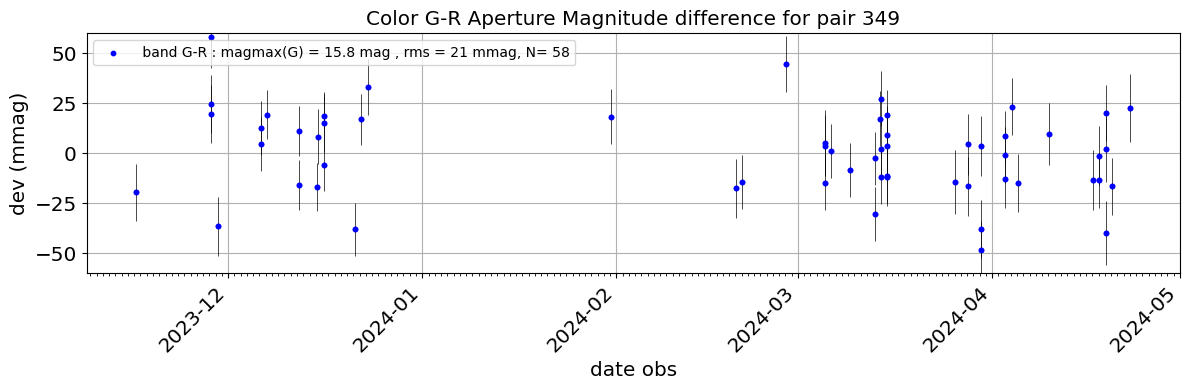

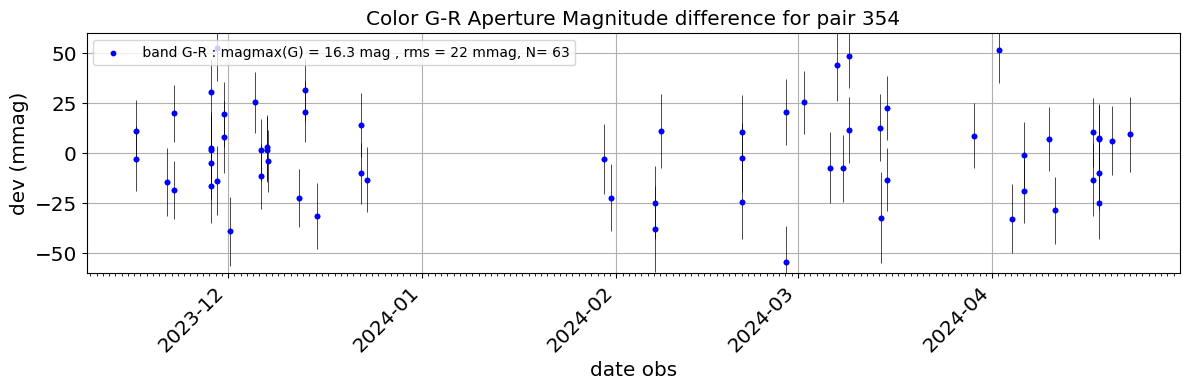

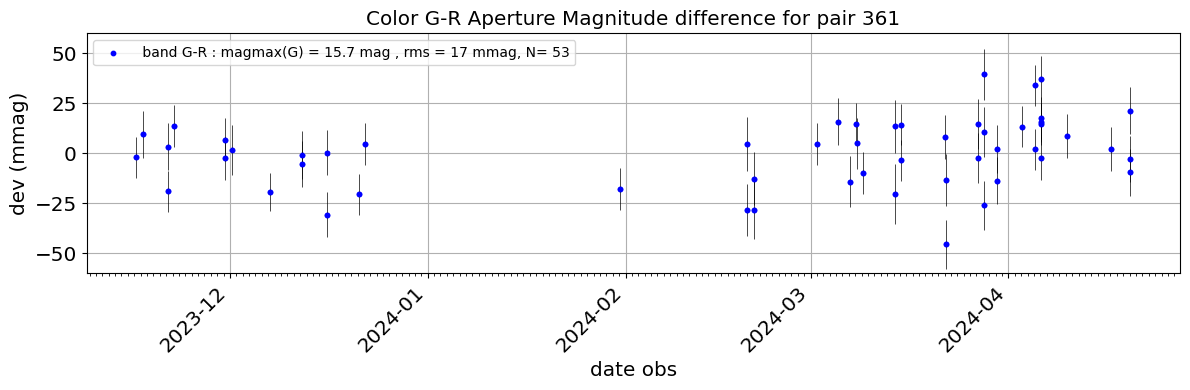

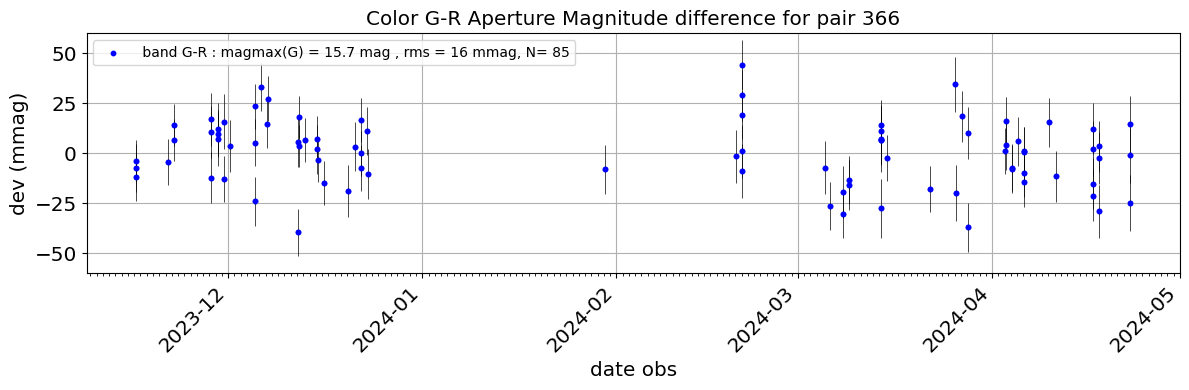

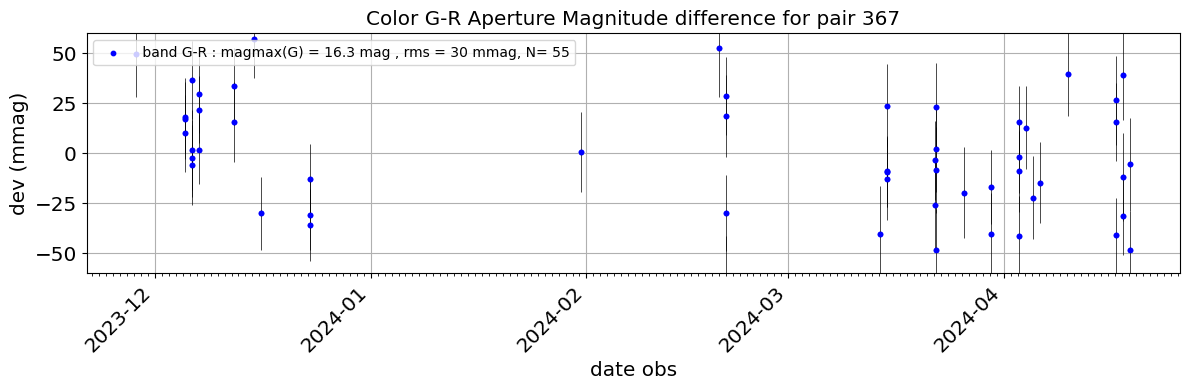

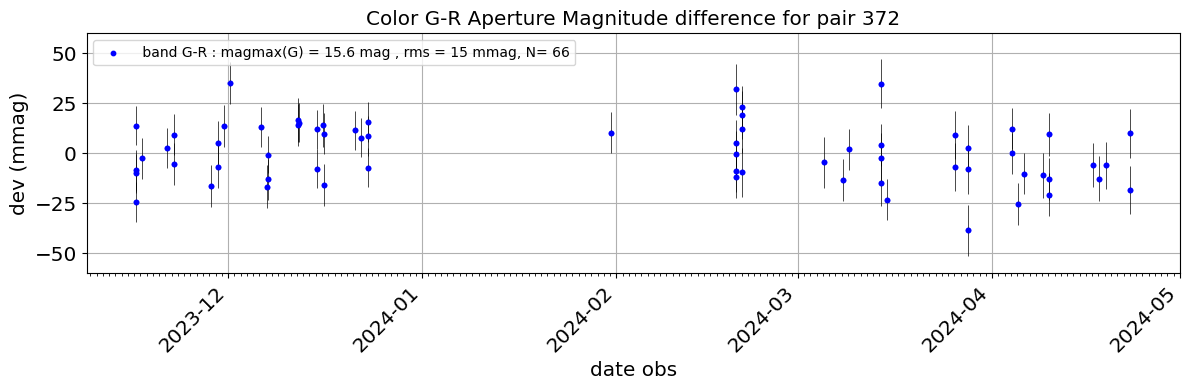

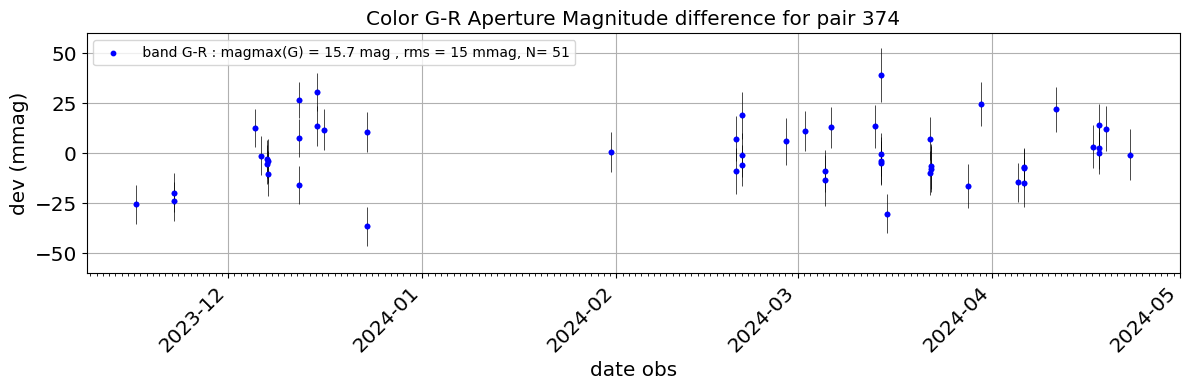

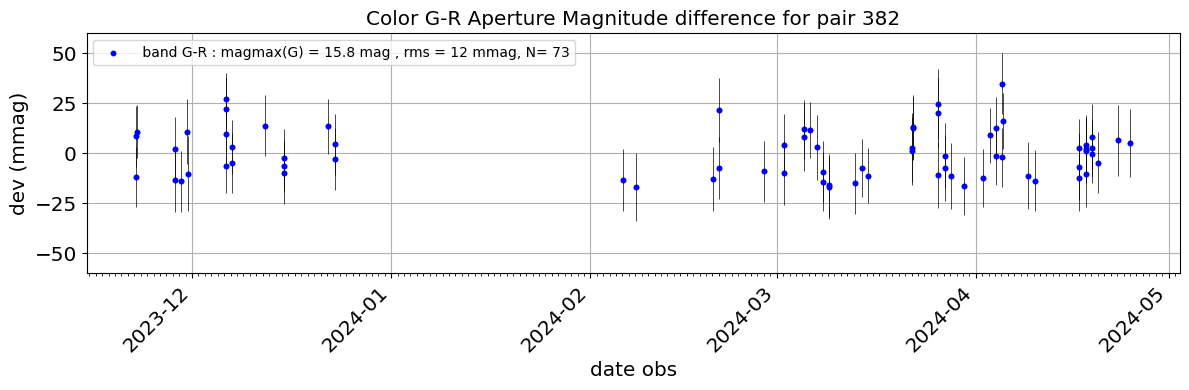

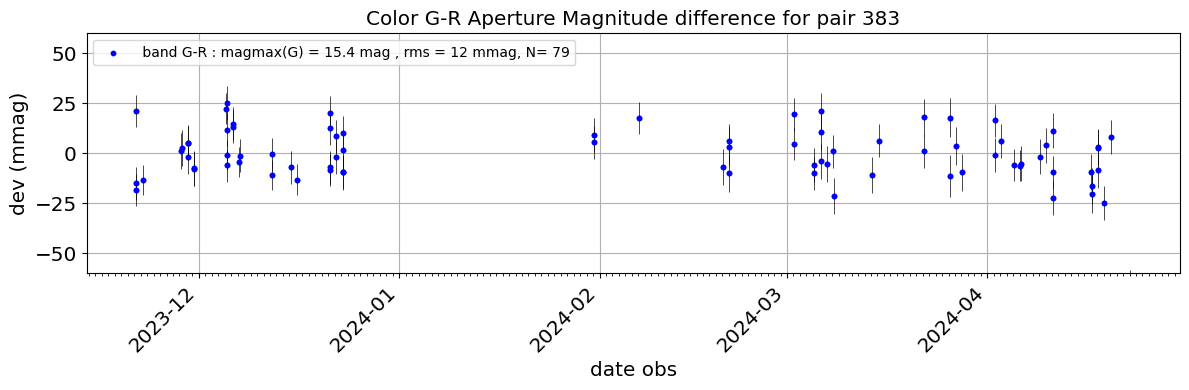

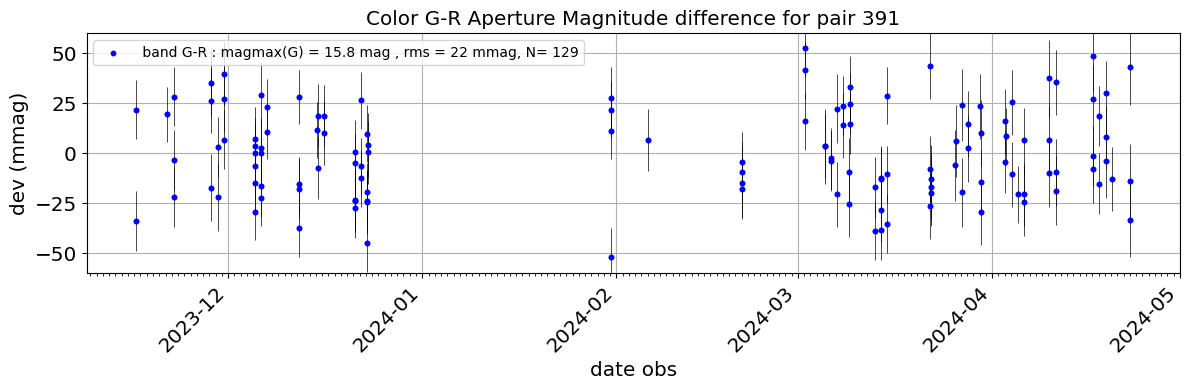

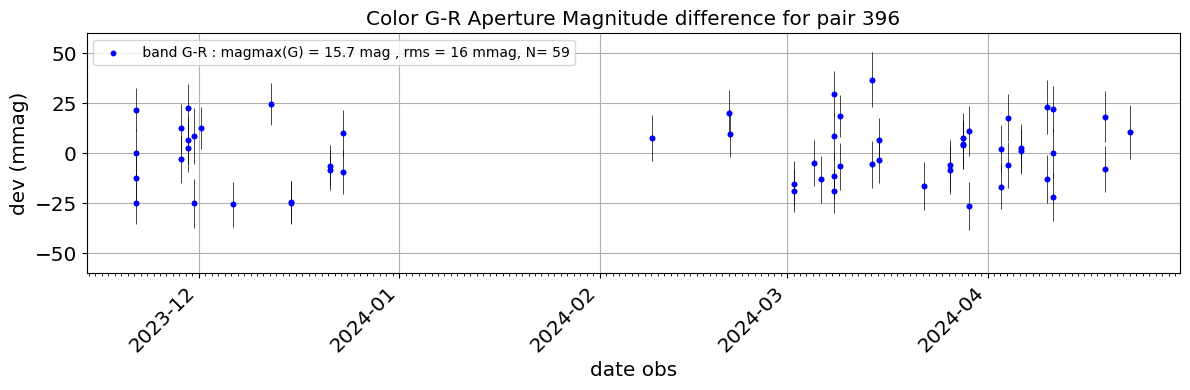

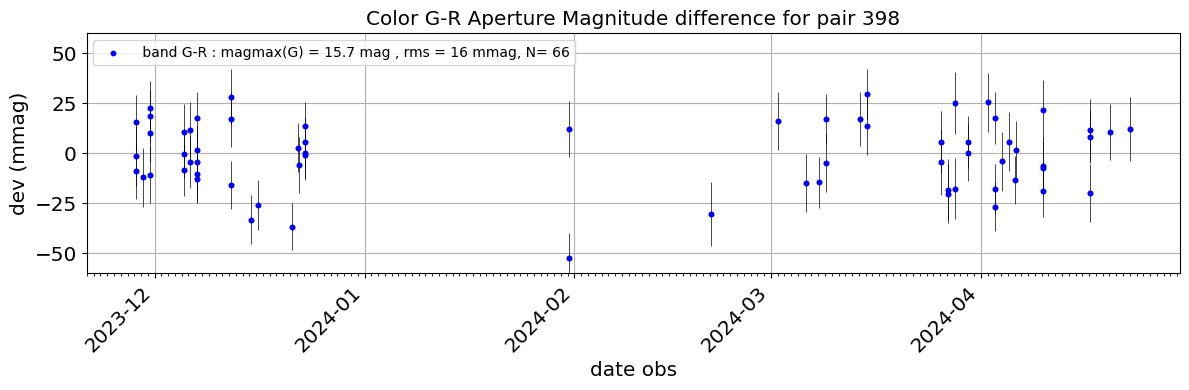

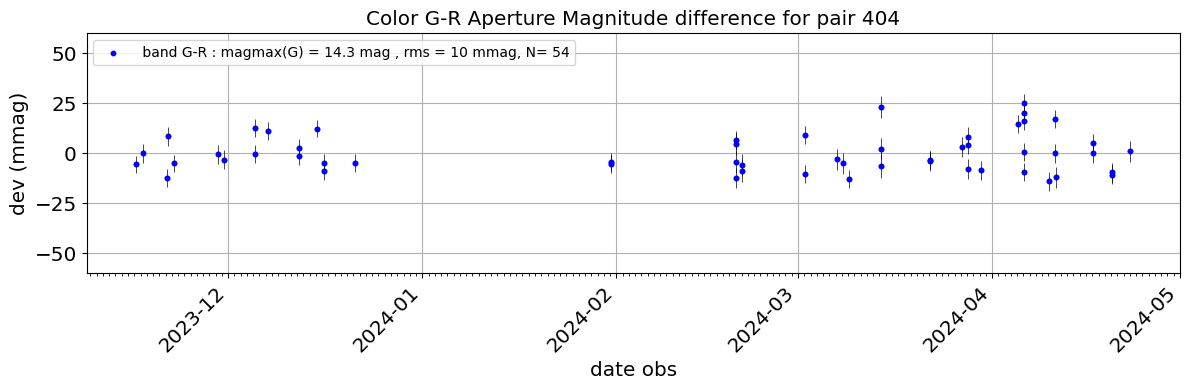

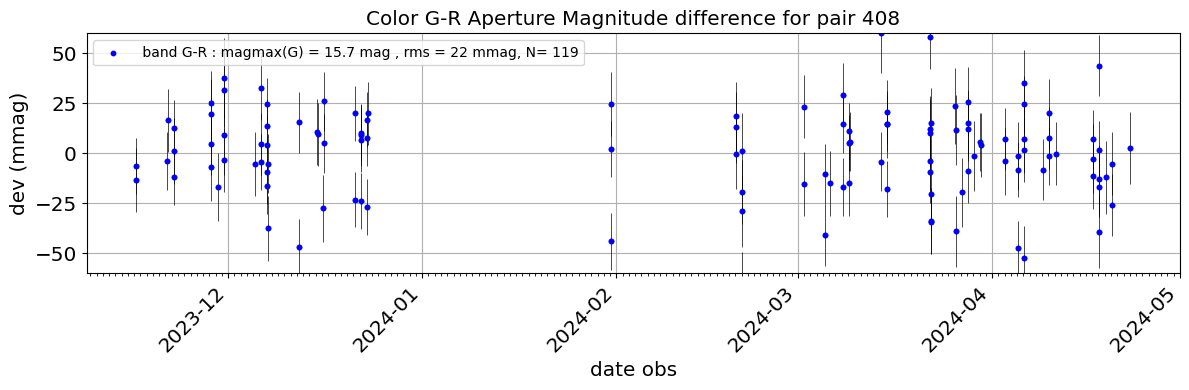

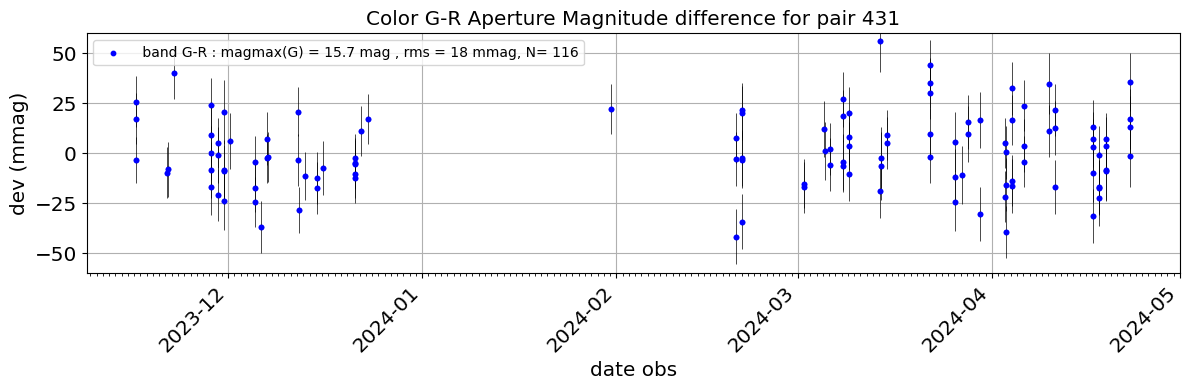

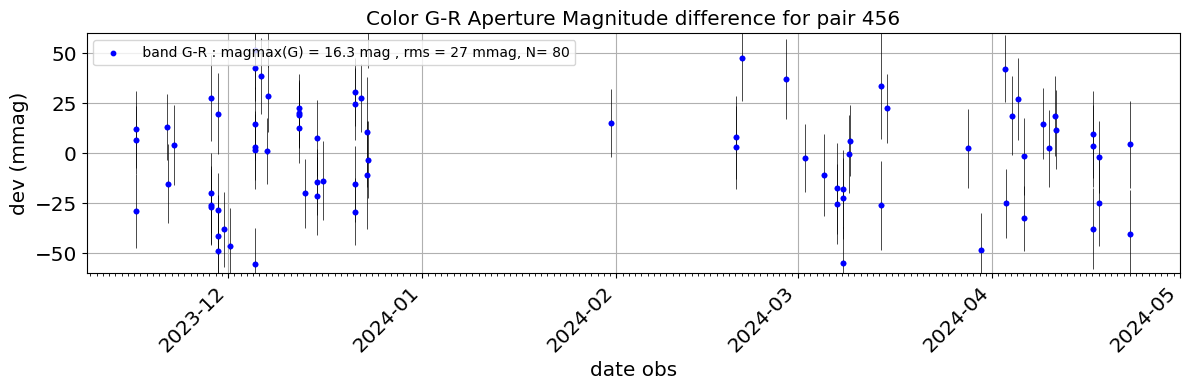

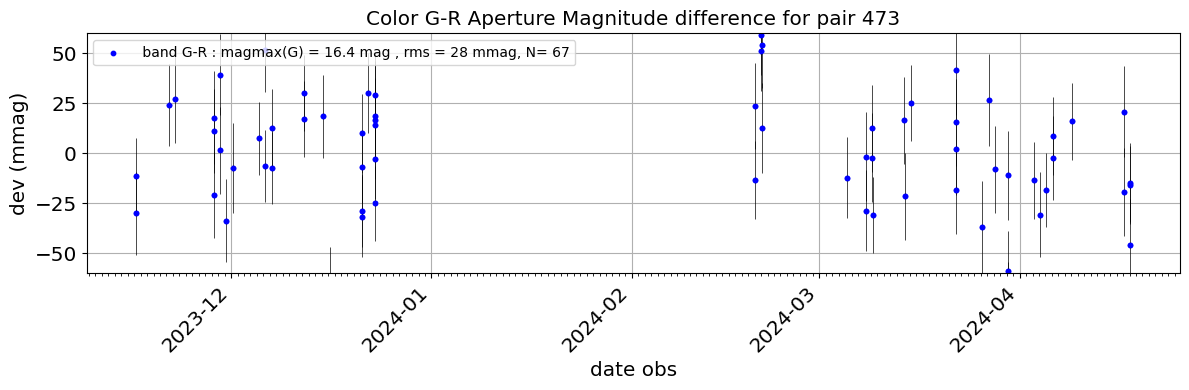

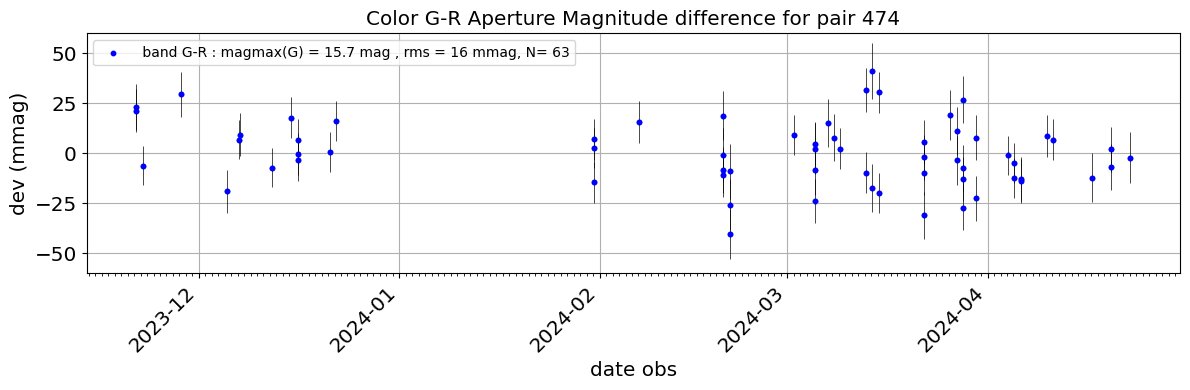

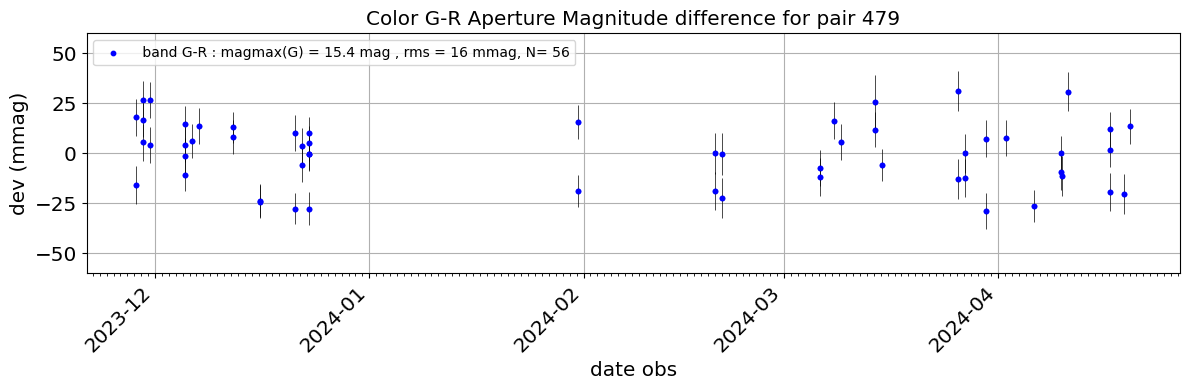

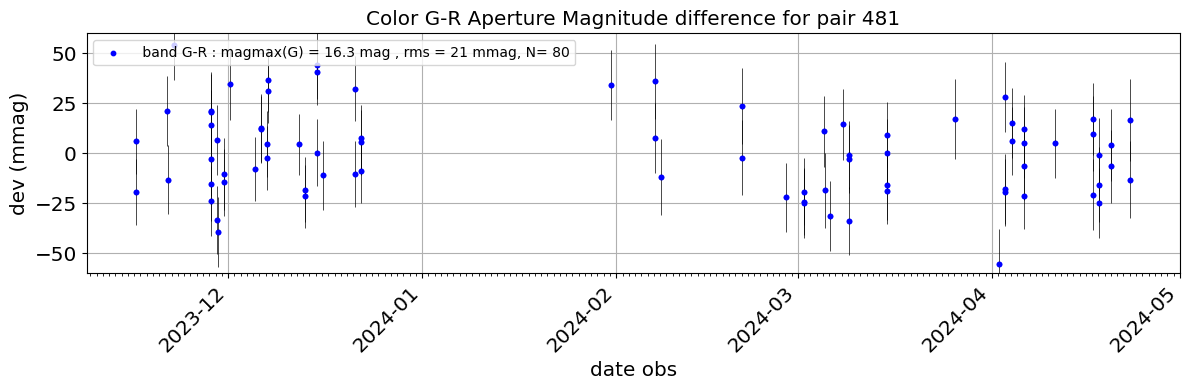

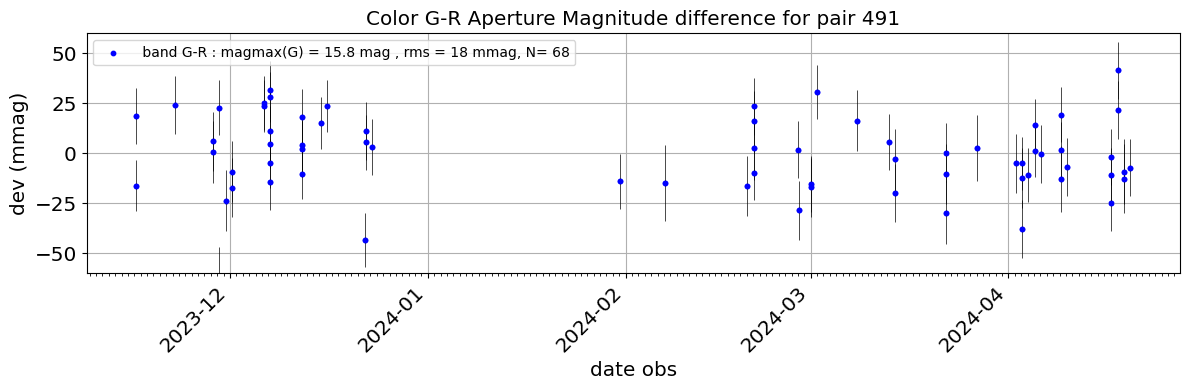

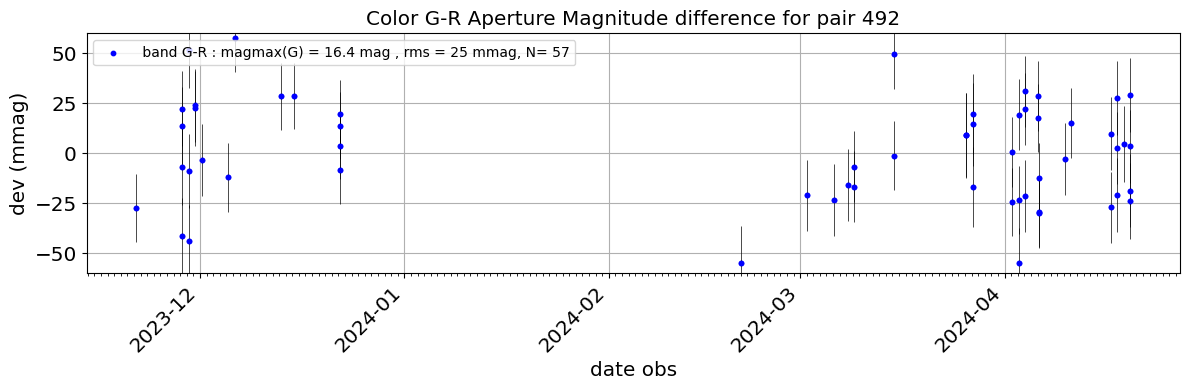

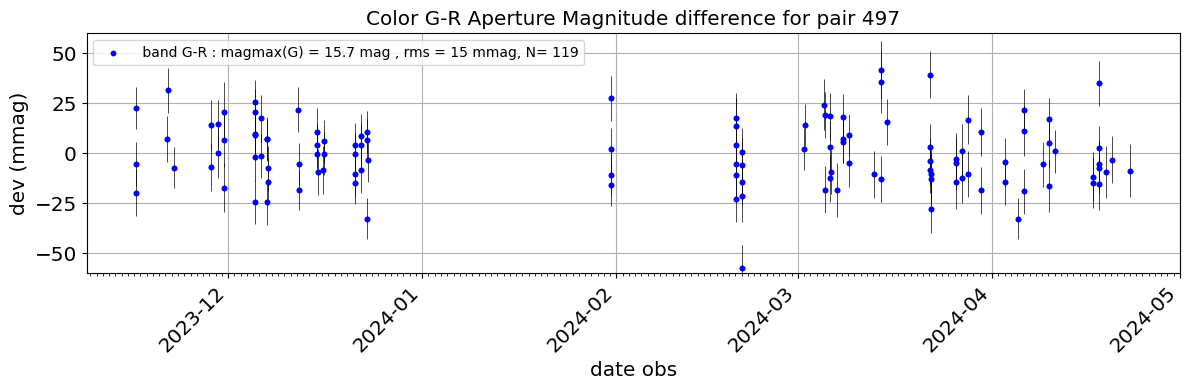

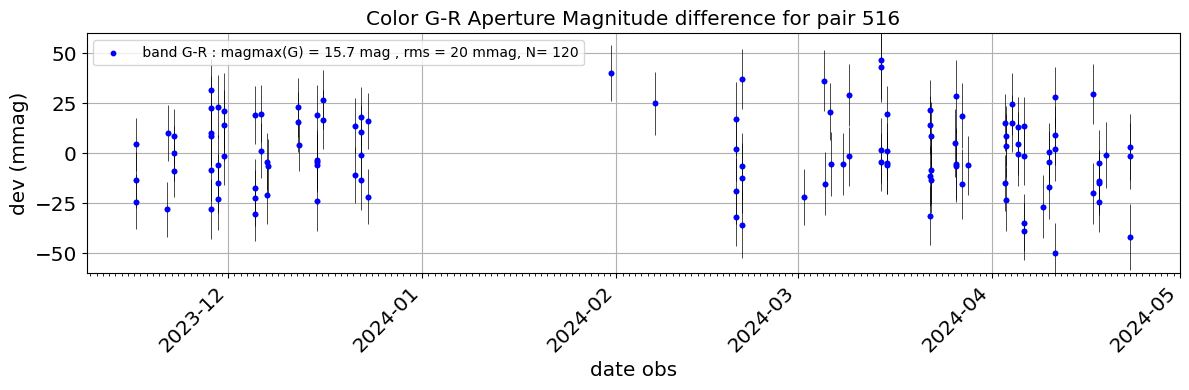

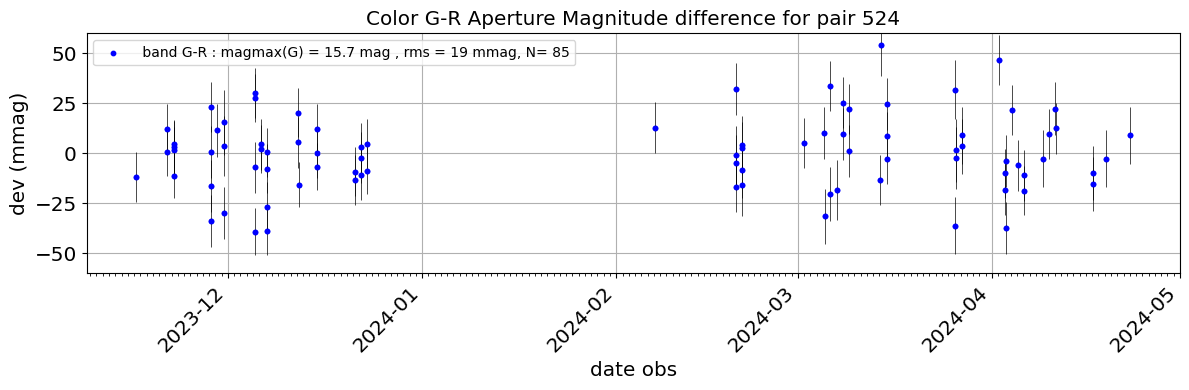

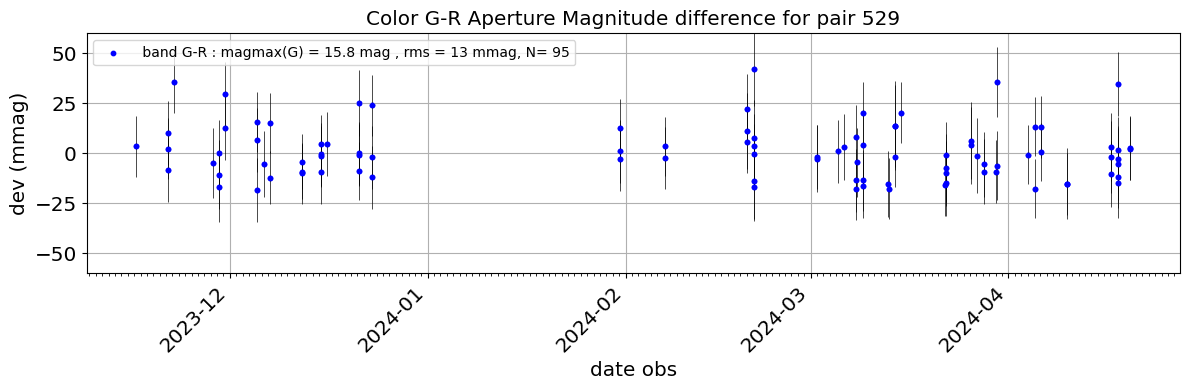

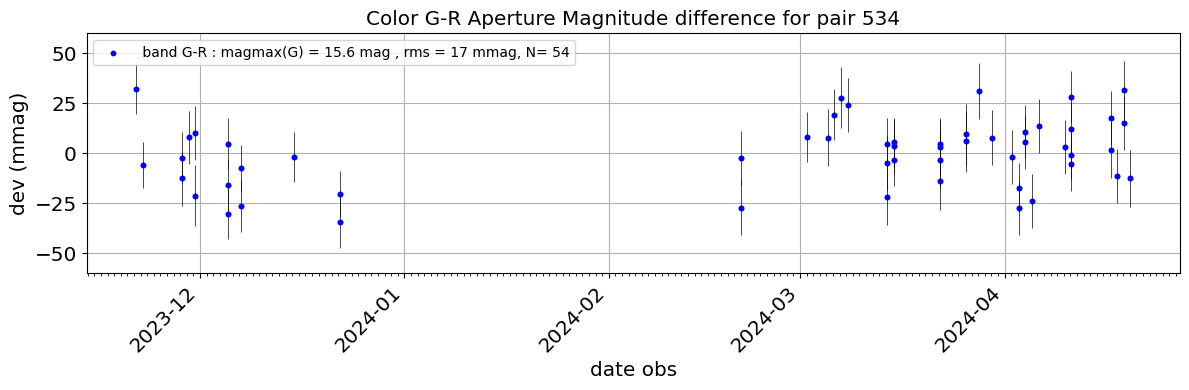

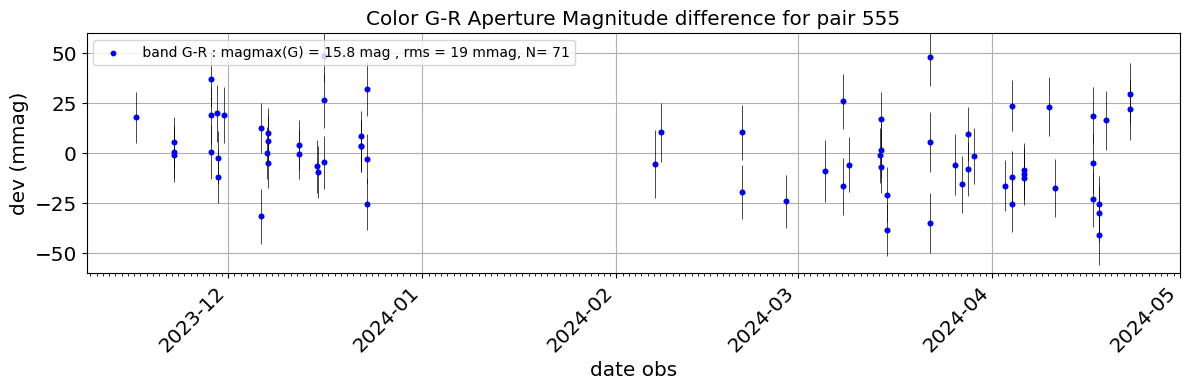

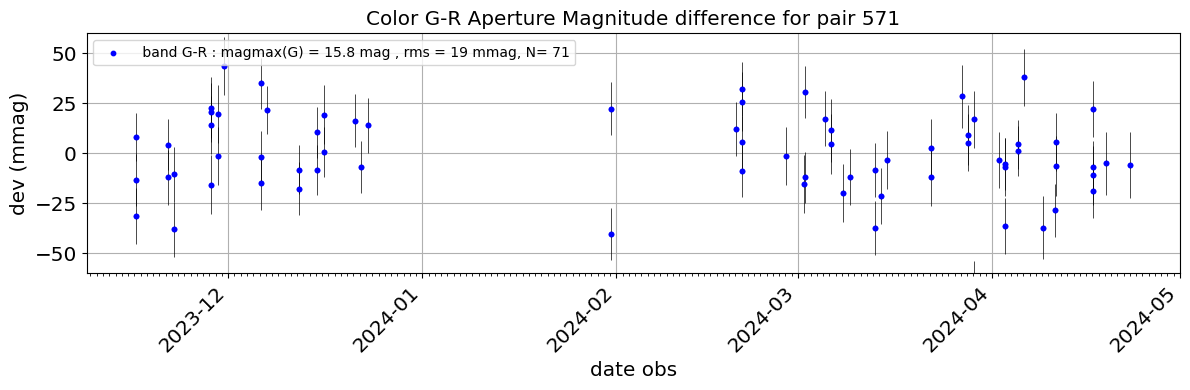

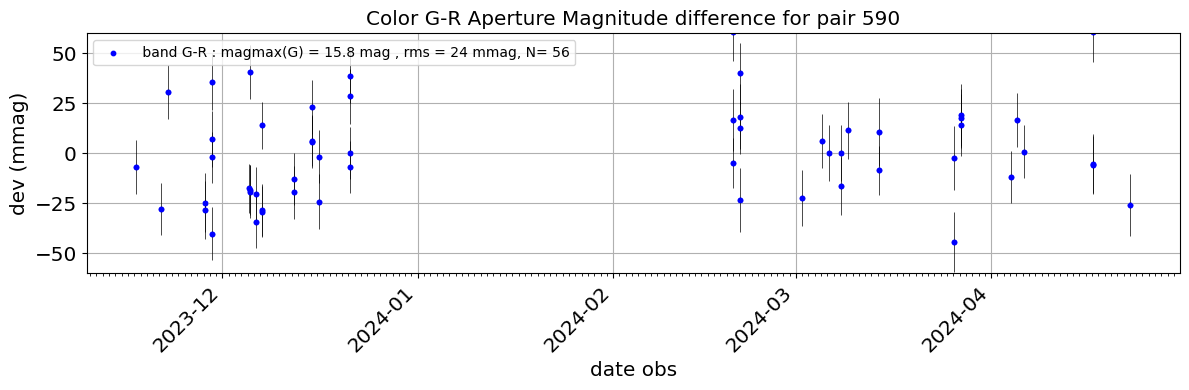

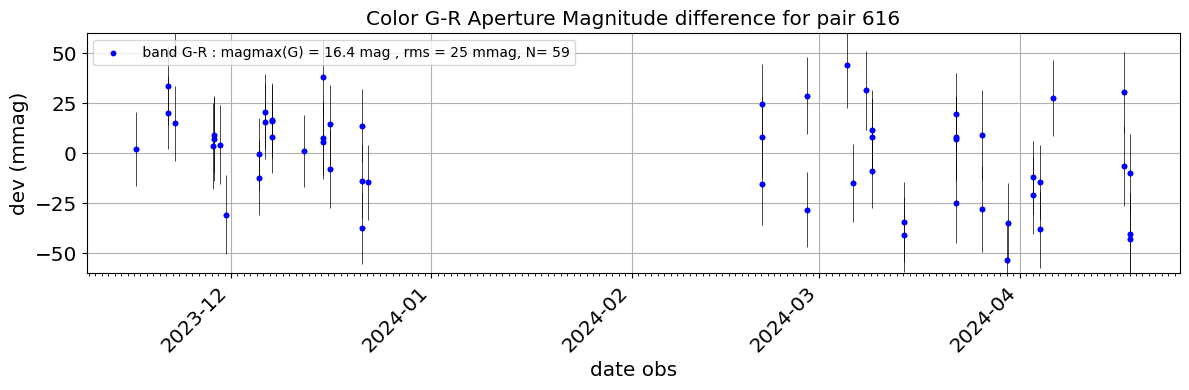

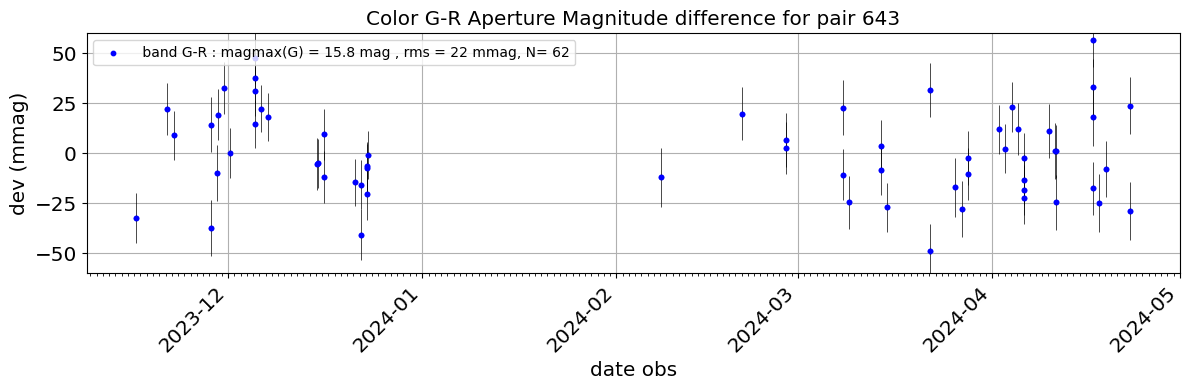

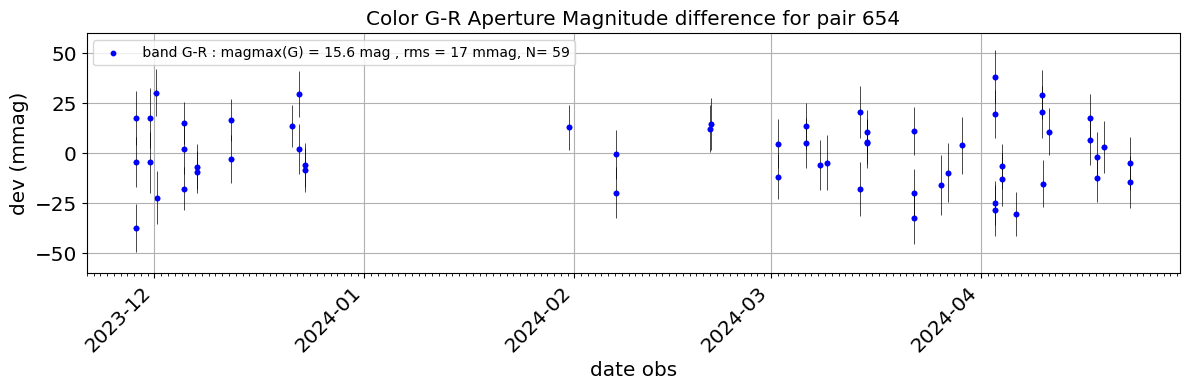

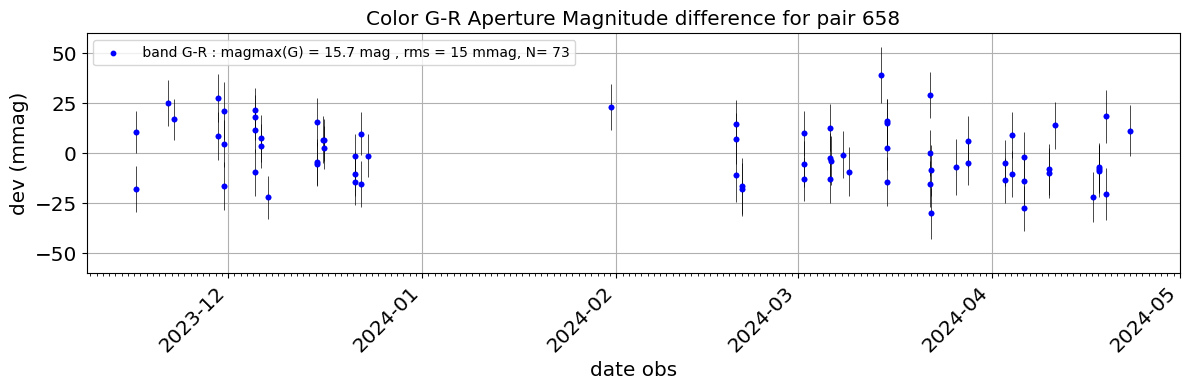

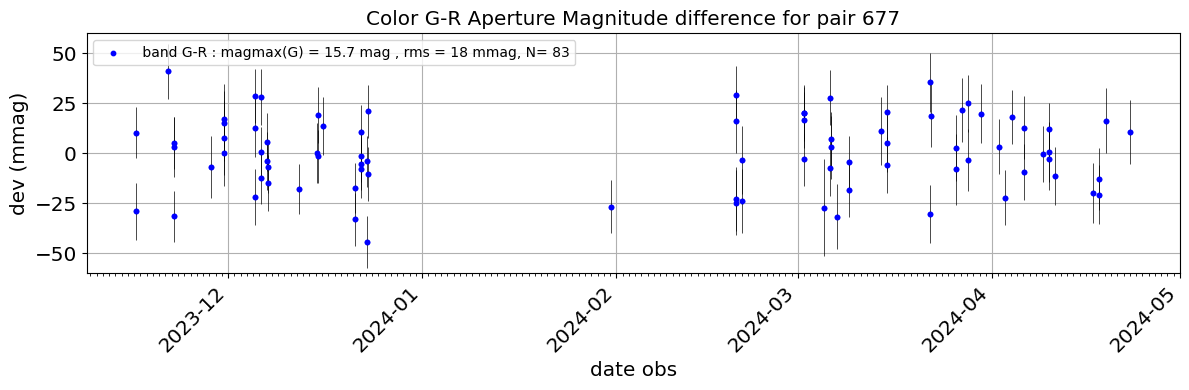

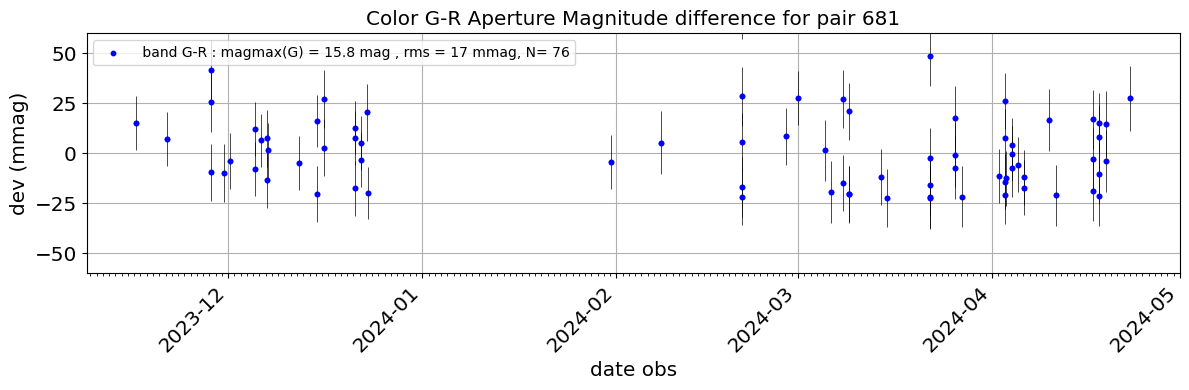

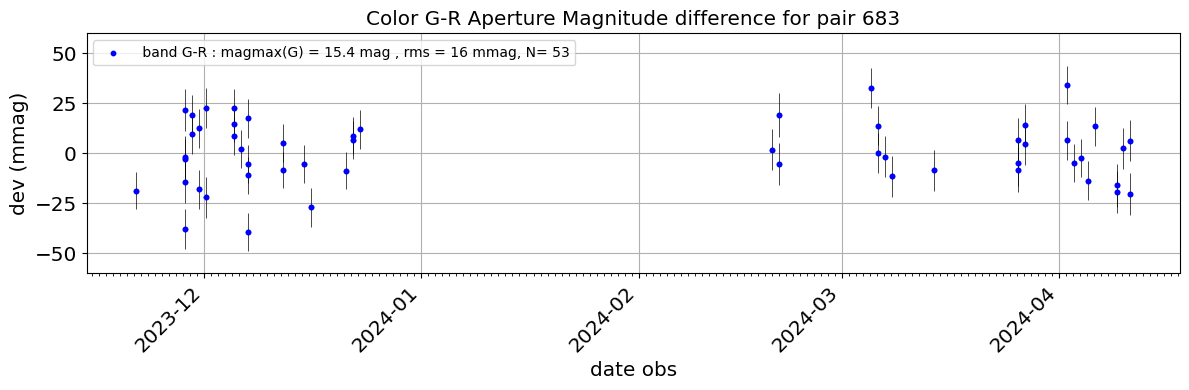

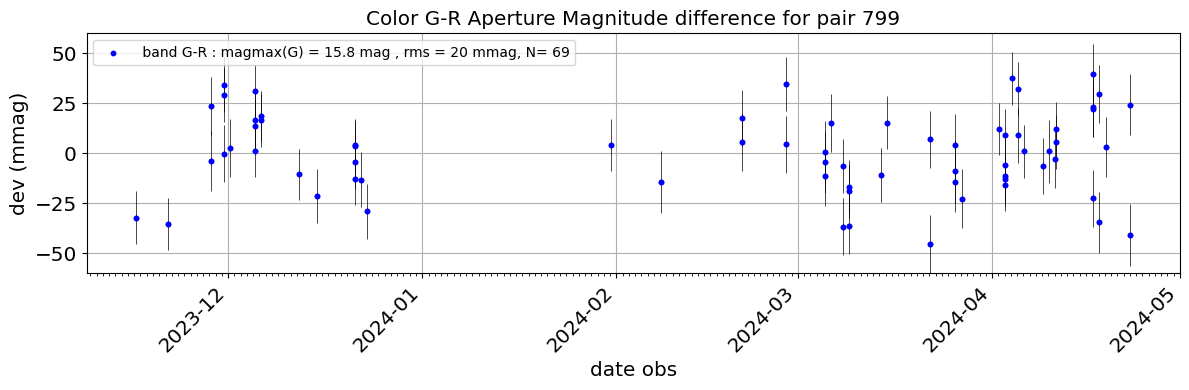

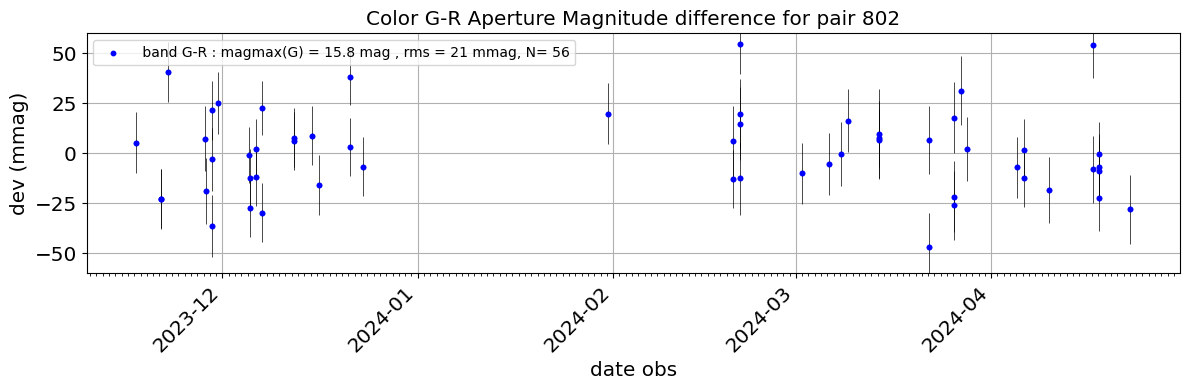

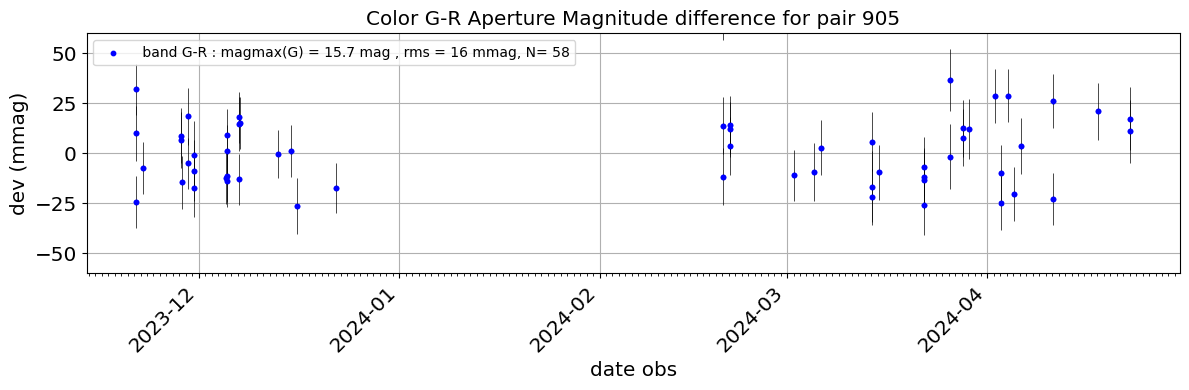

In [15]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


# loop on individual objects
n_selected_pairs = 0

for idx,df in enumerate(all_df):
    pair_num = idx
          
   
    X = pd.to_datetime(df['time1'].values)  
    
    # convert in mmag
    if FLAG_PSF:    
        Y = df['psfcol12_s12'].values*1000.
        Yerr = df['psfcol12Err_s12'].values*1000.        
    else:  
        Y = df['apcol12_s12'].values*1000.
        Yerr = df['apcol12Err_s12'].values*1000.
                 
        
    N = len(Y)
    
    if N<NMAX:
        continue
        
    n_selected_pairs +=1
        
    clippedMeanMagArray = scipy.stats.sigmaclip(Y, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))
    clippeErrorMagArray = scipy.stats.sigmaclip(Y-clippedMeanMag,low=3.0, high=3.0).clipped
    clippeErrorMagSigma = (np.sqrt(np.sum(clippeErrorMagArray**2))/np.sqrt(len(clippeErrorMagArray)))

 
    ## Plot the color light curve
    
    fig,ax = plt.subplots(1,1,figsize=(12,4))
    
    magmax = df["apmagmax_s12b1"].mean()
  
    
    avgpsfmag.append(magmax)
    residuals.append(clippeErrorMagArray)
              
    label = f" band {CBAND} : magmax({BAND1}) = {magmax:.1f} mag , rms = {clippeErrorMagSigma:.0f} mmag, N= {N}"
    ax.errorbar(X,(Y-clippedMeanMag),yerr=Yerr,fmt='.',lw=0.5,c="b",ecolor="k") 
    ax.scatter(X,Y-clippedMeanMag,marker='o',s=10,c="b",label=label) 
    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid()
        
    if FLAG_PSF:  
        ax.set_title(f"Color {CBAND} psf Magnitude difference for pair {idx}")
          
    else:
        ax.set_title(f"Color {CBAND} Aperture Magnitude difference for pair {idx}")
               
                
    ax.set_xlabel("date obs") 
    ax.set_ylabel("dev (mmag)") 
    ax.legend(loc="upper left")
    ax.set_ylim(-60,60)
    plt.tight_layout()
    plt.show()
    
  
    
    

## Histograms

In [16]:
import matplotlib.colors as mcolors
import seaborn as sns
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = f"Npair selected = {n_selected_pairs}\n Nmax > {NMAX}" 

In [17]:
mcolors.BASE_COLORS

{'b': (0, 0, 1),
 'g': (0, 0.5, 0),
 'r': (1, 0, 0),
 'c': (0, 0.75, 0.75),
 'm': (0.75, 0, 0.75),
 'y': (0.75, 0.75, 0),
 'k': (0, 0, 0),
 'w': (1, 1, 1)}

In [18]:
mcolors.TABLEAU_COLORS

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

In [19]:
mcolors.TABLEAU_COLORS.keys()

dict_keys(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

In [20]:
palette = sns.color_palette("tab10")
print(len(palette))
palette

10


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [21]:
palette[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [22]:
for idx_col in range(len(palette)):
    print(palette[idx_col],mcolors.to_hex(palette[idx_col]))

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) #1f77b4
(1.0, 0.4980392156862745, 0.054901960784313725) #ff7f0e
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313) #2ca02c
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392) #d62728
(0.5803921568627451, 0.403921568627451, 0.7411764705882353) #9467bd
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354) #8c564b
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902) #e377c2
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745) #7f7f7f
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333) #bcbd22
(0.09019607843137255, 0.7450980392156863, 0.8117647058823529) #17becf


In [23]:
sns.color_palette("hls", 6)

[(0.86, 0.3712, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999)]

In [24]:
thresholds = np.array([14.5,15.,15.5,16.,17.])
Nthr = len(thresholds)
histoLists = [ [] for idx in range(Nthr)]

my_color=["purple","b","orange","g","r"]
my_color = list(mcolors.TABLEAU_COLORS.keys())
my_color= list(mcolors.BASE_COLORS.keys())

palette = sns.color_palette("hls", Nthr)
#palette = sns.color_palette("rocket",Nthr)
#palette = sns.color_palette("husl", Nthr)
my_color= [mcolors.to_hex(palette[idx_col]) for idx_col in range(len(palette)) ]
print(my_color)

['#db5f57', '#b9db57', '#57db94', '#5784db', '#c957db']


In [25]:
# light curves
the_list_of_LC_average = avgpsfmag
the_list_of_LC_residuals = residuals
NLC = len(the_list_of_LC_average)

## Loop on threshold
for ith,th in enumerate(thresholds):
    for iobs in range(NLC):
        mag = the_list_of_LC_average[iobs]
        res = the_list_of_LC_residuals[iobs] 
        if mag < th:
            histoLists[ith].append(res)

In [26]:
for ith,th in enumerate(thresholds):
    print(ith,th,len(histoLists[ith]))
    if len(histoLists[ith])>0:
        histoLists[ith] = np.hstack(histoLists[ith])
    print(ith,th,len(histoLists[ith]))
 


0 14.5 2
0 14.5 126
1 15.0 4
1 15.0 264
2 15.5 20
2 15.5 1358
3 16.0 95
3 16.0 7334
4 17.0 117
4 17.0 8834


Text(0.5, 0, 'residuals (mmag)')

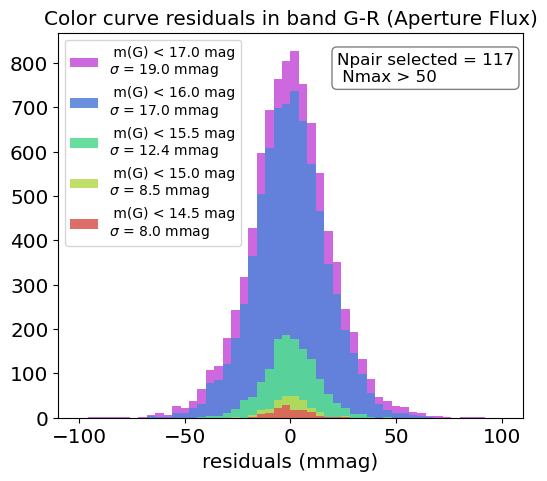

In [31]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
for ith,th in enumerate(thresholds):
    data = histoLists[Nthr-1-ith]
    if len(data)>2:
        sigma = np.std(data)
        m = thresholds[Nthr-1-ith]
        label = f" m({BAND1}) < {m:.1f} mag\n$\sigma$ = {sigma:.1f} mmag"
        ax.hist(data,bins=50,range=(-100,100),facecolor=my_color[Nthr-1-ith],alpha=0.9,label=label)
        
ax.legend(loc="upper left")
if FLAG_PSF:
    ax.set_title(f"Color curve residuals in band {CBAND} (PSF Flux)")
else:
    ax.set_title(f"Color curve residuals in band {CBAND} (Aperture Flux)")

# place a text box in upper left in axes coords
ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)    
ax.set_xlabel("residuals (mmag)")